# Data loading

In [ ]:
import sqlalchemy
import pandas as pd
import numpy as np

db = sqlalchemy.create_engine('sqlite:///results.db')
instr = 'maxi'
central_value = "d_fit_weighted_median"

try:
    with db.connect() as conn:
        print(f"Opened SQLite database with sqlalchemy version {sqlalchemy.__version__} successfully.")
        distances = (pd.read_sql('SELECT d FROM "'+instr+'" WHERE '+central_value+' IS NOT NULL AND r = 0.5 AND T=0.7 AND e=1500',conn))['d'].values
        na_distances = (pd.read_sql('SELECT d FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r = 0.5 AND T=0.7 AND e=1500',conn))['d'].values
        tight_distances_sql = (pd.read_sql('SELECT d FROM "'+instr+'" WHERE (ABS(diff_d)/'+central_value+') <= 0.5 AND r = 0.5 AND T=0.7 AND e=1500',conn))['d'].values
        aggregated_data = pd.read_sql('SELECT * FROM "'+instr+'" WHERE r = 0.5 AND T=0.7 AND e=1500',conn)
        tight_distances = (aggregated_data[(np.abs(aggregated_data['d']-aggregated_data[central_value])/aggregated_data['d']) <= 0.5])['d'].values
        na_nH = (pd.read_sql('SELECT nH FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r = 0.5 AND T=0.7 AND e=1500',conn))['nH'].values
        na_d_fit_params = (pd.read_sql('SELECT g,T,a,m,i,r,e FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r = 0.5 AND T=0.7 AND e=1500',conn)).to_dict('records')

except Exception as e:
    print("Failed to open database:", e)

Opened SQLite database with sqlalchemy version 2.0.30 successfully.


# Overall matplotlib settings

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set MNRAS-compatible font and style
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 8
mpl.rcParams['axes.titlesize'] = 7
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['legend.fontsize'] = 8

# Overall distance

1.0
3.91959378578653
0.010001256913021617


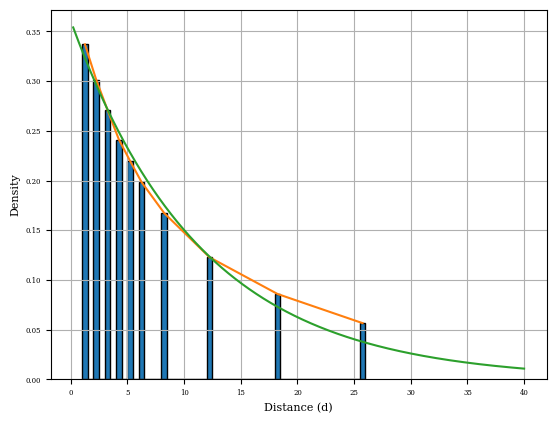

In [35]:
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt


def exp_decay(x,a,b):
    return b*np.exp(-a*x)

def volume_density_exp_decay(x,L):
    return (1/(2*(L**3)))*(x**2)*np.exp(-(x/L))

n, bins,_ = plt.hist(distances, bins=50, edgecolor='black',density = True)

print(n.sum()*(bins[1]-bins[0]))

# plt.show()

xdata = bins[:-1] + ((bins[1:]-bins[:-1])/2) 

xdata = xdata[n>0]

ydata = n[n>0]

popt, pcov = curve_fit(exp_decay, xdata, ydata)

# distances_numpy = np.array(distances)
# kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(distances_numpy.reshape(-1, 1))
distances_plot = np.linspace(0.215, 40, 3979)
# density = np.exp(kde.score_samples(distances_plot.reshape(-1, 1)))

density = exp_decay(distances_plot,*popt)

# density = density/(density.sum()*(distances_plot[1]-distances_plot[0]))

print(density.sum()*(distances_plot[1]-distances_plot[0]))

print((distances_plot[1]-distances_plot[0]))

plt.plot(xdata,ydata)
plt.plot(distances_plot,density)
plt.xlabel('Distance (d)')
plt.ylabel('Density')
# plt.yscale('log')
# plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
np.save(f'{instr}_density.npy',density)
plt.grid()
plt.show()

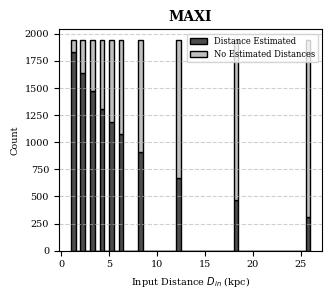

[[1828.    0. 1634.    0. 1469.    0. 1308.    0. 1190.    0. 1076.    0.
     0.    0.  907.    0.    0.    0.    0.    0.    0.    0.  666.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  466.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.  307.]
 [1944.    0. 1944.    0. 1944.    0. 1944.    0. 1944.    0. 1944.    0.
     0.    0. 1944.    0.    0.    0.    0.    0.    0.    0. 1944.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1944.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0. 1944.]]


In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set MNRAS-compatible font and style
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 7
mpl.rcParams['axes.titlesize'] = 7
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['legend.fontsize'] = 6

# Combine distances and na_distances into a list of datasets
data = [distances, na_distances]

# Create the histogram
fig, ax = plt.subplots(figsize=(10/3, 3))  # Suitable for single-column MNRAS format
counts, bins, _ = ax.hist(data, bins=50, edgecolor='black', stacked=True, 
        label=['Distance Estimated', 'No Estimated Distances'], 
        color=['#4d4d4d', '#bfbfbf'], alpha=1)

# Set labels and title with LaTeX formatting
ax.set_xlabel(r'Input Distance $D_{in}$ (kpc)', fontsize=7)
ax.set_ylabel('Count', fontsize=7)
# ax.set_title('Stacked Histogram of Distances', fontsize=14)
ax.set_title(f"{instr.upper()}", fontsize=10, fontweight='bold')

# Add a grid with dashed lines
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add a legend
ax.legend()

# Adjust layout for clarity
plt.tight_layout()

# Save the figure in a high-resolution format suitable for publication
# plt.savefig(f'plots/{instr}/stacked_histogram_distances_{instr}.pdf', dpi=600)

# Show the plot
plt.show()

print(counts)


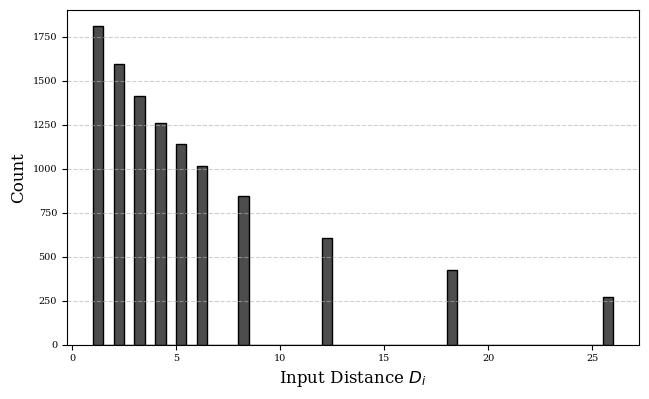

In [7]:
# Create the histogram
fig, ax = plt.subplots(figsize=(6.5, 4))  # Suitable for single-column MNRAS format
ax.hist(tight_distances, bins=50, edgecolor='black',color='#4d4d4d')

# Set labels and title with LaTeX formatting
ax.set_xlabel(r'Input Distance $D_i$', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
# ax.set_title('Stacked Histogram of Distances', fontsize=14)

# Add a grid with dashed lines
ax.grid(axis='y', linestyle='--', alpha=0.6)

# # Add a legend
# ax.legend()

# Adjust layout for clarity
plt.tight_layout()

# Save the figure in a high-resolution format suitable for publication
# plt.savefig(f'plots/{instr}/constrained_distances_{instr}.pdf', dpi=600)

# Show the plot
plt.show()

Endpoints array x: [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  9.5 14.5 21.5 30.5]
Computed midpoints: [ 1.  2.  3.  4.  5.  6.  8. 12. 18. 26.]


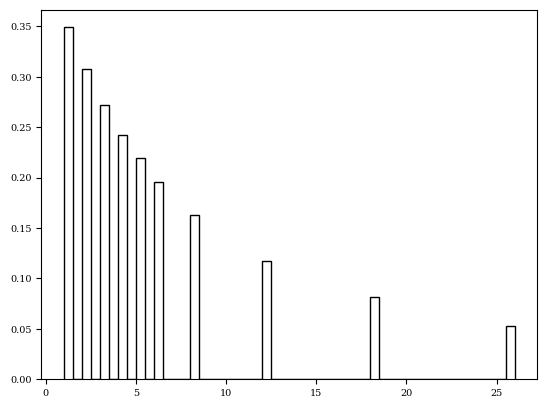

[ 1  2  3  4  5  6  8 12 18 26]
[0.34900752 0.307381   0.27192137 0.24243592 0.21950279 0.19560609
 0.16265176 0.11697822 0.08190403 0.05261129]
4
[0.4 0.4 1. ]
0.00013394471189688122 [0.09533485 0.30047645 2.08162278] <function exp_decay at 0x7f668fe5a660>
4
[0.4 0.4 1. ]
1.5305973828076057e-06 [-8.68552442  0.31808852 40.57503361] <function weibull at 0x7f668fe5a8e0>
3
[0.4 1. ]
3.0289374052535423e-06 [-14.26445475 127.92478815] <function cauchy at 0x7f668eb51940>
4
[0.4 0.4 1. ]
0.03632584249090303 [0.23626607 0.4        1.        ] <function power_law at 0x7f668eb51e40>
4
[0.4 0.4 1. ]
1.2329403466807162e-06 [  0.75359464 -11.8903979   41.0746509 ] <function power_law_tail at 0x7f668eb51300>
3
[0.4 1. ]
0.012656646282437766 [ 1.01931631 -0.12291111] <function volume_density_exp_decay at 0x7f668eb51a80>
4
[0.4 0.4 1. ]
2.364170648819914e-06 [-4.56386949  0.39787848  8.55558075] <function half_gen_normal at 0x7f668eb51b20>
6
[0.4 0.4 0.4 0.4 1. ]
0.007735527752979414 [0.31090779 0.07

/tmp/ipykernel_861270/3021214132.py:113: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, xdata, ydata,p0=p0, maxfev=10000)


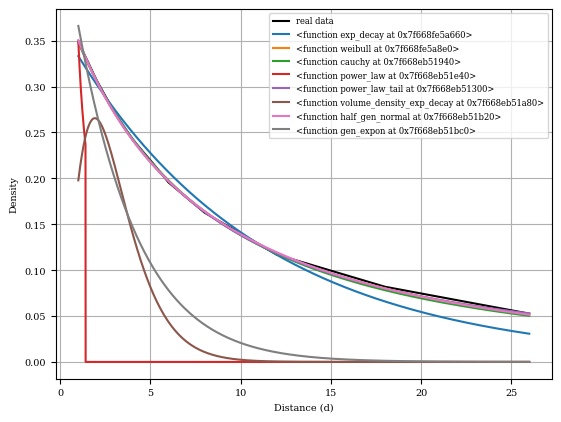

1.0
1.177629938358218


In [8]:
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit
from scipy.stats import pareto
from scipy.stats import lognorm
from scipy.stats import genpareto
from scipy.stats import weibull_min
from scipy.stats import exponweib
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.stats import halfcauchy
from scipy.stats import halfgennorm
from scipy.stats import powerlaw
from scipy.stats import genexpon
from scipy.stats import poisson
import inspect

# Given midpoints array
m = np.array([1, 2, 3, 4, 5, 6, 8, 12, 18, 26])
n = m.size  # number of midpoints

# Allocate endpoints array (n+1 points)
x = np.empty(n + 1)

# Choose x[0] as described:
x[0] = m[0] - (m[1] - m[0]) / 2.0

# Use the recurrence relation:
for i in range(n):
    x[i + 1] = 2 * m[i] - x[i]

print("Endpoints array x:", x)

# Verify the midpoints:
m_computed = (x[:-1] + x[1:]) / 2.0
print("Computed midpoints:", m_computed)

def exp_decay(x,a,b,c):
    return b*np.exp(-a*(x-c))

def weibull(x,b,c,d):
    return d*weibull_min.pdf(x,c=c, loc=b)

def power_law(x,a,b,d):
    return d*powerlaw.pdf(x, a, loc=b)

def power_law_tail(x,b,c,d):
    return d*pareto.pdf(x, b=b, loc=c)

def power_law_tail_gen(x,b,c,d):
    return d*genpareto.pdf(x, c=c, loc=b)

def log_normal(x,b,c,d):
    return d*lognorm.pdf(x, s=b, loc=c)

def cauchy(x,a,d):
    return d*halfcauchy.pdf(x, loc=a)

def volume_density_exp_decay(x,L,c):
    return (1/(2*(L**3)))*((x-c)**2)*np.exp(-((x-c)/L))

def half_gen_normal(x,a,b,d):
    return d*halfgennorm.pdf(x, beta=b, loc=a)

def gen_expon(x,a,b,c,d,f):
    return f*genexpon.pdf(x, a, b, c, loc=d)

def poisson_dis(x,mu):
    return poisson.pmf(x, mu)



n, bins,_ = plt.hist(tight_distances, bins= 50, edgecolor='black',density = True,histtype="step")
plt.show()

# n = n/n.sum()

# print(n.sum()*(bins[1]-bins[0]))

# plt.show()

xdata = bins[:-1] + ((bins[1:]-bins[:-1])/2) 

xdata = xdata[n>0]

ydata = n[n>0]

xdata = m

print(xdata)
print(ydata)

distances_plot = np.linspace(1, 26, 10000)

# f_interp = interp1d(xdata, ydata, kind='cubic')
# f_interp = UnivariateSpline(xdata, ydata, s=0)

# ydata = f_interp(distances_plot)
# xdata = distances_plot

# fit_func_list = [log_normal]
fit_func_list = [exp_decay,weibull,cauchy,power_law,power_law_tail,volume_density_exp_decay,half_gen_normal,gen_expon]
mse_list = []
best_fit_param_list = []

for fit_func in fit_func_list:
    sig = inspect.signature(fit_func)
    print(len(sig.parameters))
    popt = None
    p0 = np.repeat(0.4,len(sig.parameters)-2)
    p0 = np.append(p0,1)
    print(p0)
    try:
        popt, pcov = curve_fit(fit_func, xdata, ydata,p0=p0, maxfev=10000)

    except Exception as a: 
       print(a)
       
    best_fit_param_list.append(popt)

    mse = np.mean( (ydata - fit_func(xdata,*popt))**2 )
    print(mse,popt,fit_func)
    mse_list.append(mse)

mse_list = np.array(mse_list)
print(f"lowest mse: {mse_list.min()}, fit function: {fit_func_list[mse_list.argmin()]}, best-fit params {best_fit_param_list[mse_list.argmin()]}")
best_function = fit_func_list[mse_list.argmin()]

distances_numpy = np.array(tight_distances)
# kde = KernelDensity(kernel='exponential', bandwidth=5).fit(distances_numpy.reshape(-1, 1))

# density = np.exp(kde.score_samples(distances_plot.reshape(-1, 1)))

# density = density/(density.sum()*(distances_plot[1]-distances_plot[0]))


plt.plot(xdata,ydata,'k',label="real data")
for i,fit_func in enumerate(fit_func_list):
    density = fit_func(distances_plot,*best_fit_param_list[i])
    plt.plot(distances_plot,density,label=str(fit_func))
    plt.xlabel('Distance (d)')
    plt.ylabel('Density')
# plt.yscale('log')
# plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
# np.save(f'{instr}_density.npy',density)
plt.legend()
plt.grid()
plt.show()

print(ydata.sum()*(bins[1]-bins[0]))
print(density.sum()*(distances_plot[1]-distances_plot[0]))

Endpoints array x: [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  9.5 14.5 21.5 30.5]
Computed midpoints: [ 1.  2.  3.  4.  5.  6.  8. 12. 18. 26.]


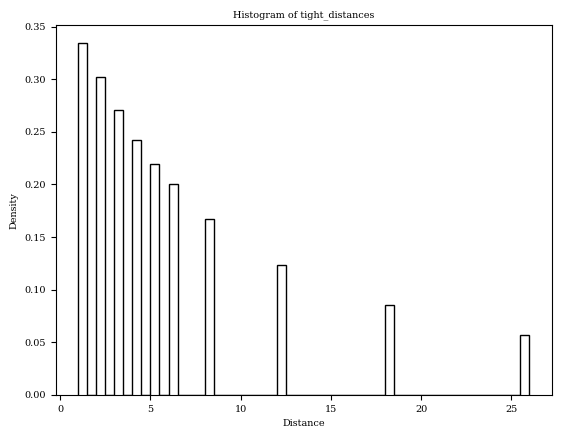

xdata (midpoints): [ 1  2  3  4  5  6  8 12 18 26]
ydata (histogram values at midpoints): [0.33461047 0.30189138 0.27026698 0.24198747 0.21918141 0.19996351
 0.16681871 0.12303108 0.08568996 0.05655902]

Fitting function 'exp_decay' requires 3 parameters.
Initial guess p0: [0.4 0.4 1. ]
MSE: 9.975233982007544e-05
Parameters: [ 0.08677095  0.38745861 -1.11739289]
Parameter errors: [5.61609352e-03 1.15950762e+05 3.44884748e+06]

Fitting function 'weibull' requires 3 parameters.
Initial guess p0: [0.4 0.4 1. ]
MSE: 1.9627014752472877e-06
Parameters: [-10.56030088   0.32828639  49.56970159]
Parameter errors: [0.62974056 0.01221006 3.65350017]

Fitting function 'cauchy' requires 2 parameters.
Initial guess p0: [0.4 1. ]
MSE: 1.9403053136236386e-06
Parameters: [-15.93738927 151.90147986]
Parameter errors: [0.16519876 2.60783332]

Fitting function 'power_law' requires 3 parameters.
Initial guess p0: [0.4 0.4 1. ]
MSE: 0.03642733023240119
Parameters: [0.22524848 0.4        1.        ]
Paramete

/tmp/ipykernel_3726448/3106242770.py:138: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, xdata, ydata, p0=p0, maxfev=10000)


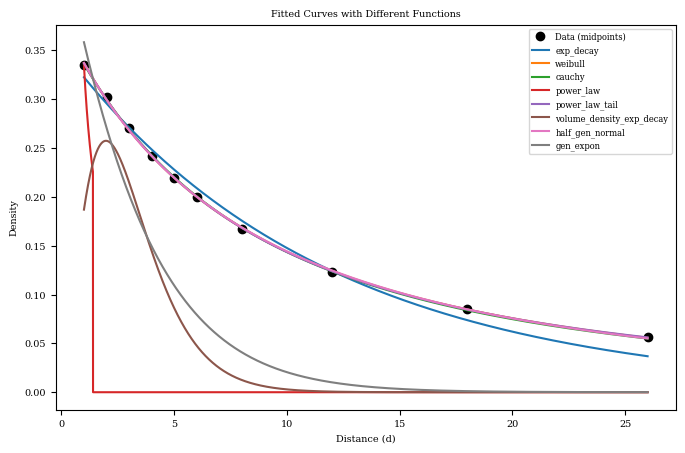

In [ ]:
# %% [Cell 1]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit
from scipy.stats import pareto, lognorm, genpareto, weibull_min, exponweib, halfcauchy, halfgennorm, powerlaw, genexpon, poisson
from scipy.interpolate import interp1d, UnivariateSpline
import inspect


# Given midpoints array
m = np.array([1, 2, 3, 4, 5, 6, 8, 12, 18, 26])
n = m.size  # number of midpoints

# Allocate endpoints array (n+1 points)
x = np.empty(n + 1)

# Choose x[0] as described:
x[0] = m[0] - (m[1] - m[0]) / 2.0

# Use the recurrence relation:
for i in range(n):
    x[i + 1] = 2 * m[i] - x[i]

print("Endpoints array x:", x)

# Verify the midpoints:
m_computed = (x[:-1] + x[1:]) / 2.0
print("Computed midpoints:", m_computed)

# -------------------------------
# Define fitting functions
# -------------------------------
def exp_decay(x,a,b,c):
    return b*np.exp(-a*(x-c))

def weibull(x,b,c,d):
    return d*weibull_min.pdf(x,c=c, loc=b)

def power_law(x,a,b,d):
    return d*powerlaw.pdf(x, a, loc=b)

def power_law_tail(x,b,c,d):
    return d*pareto.pdf(x, b=b, loc=c)

def power_law_tail_gen(x,b,c,d):
    return d*genpareto.pdf(x, c=c, loc=b)

def log_normal(x,b,c,d):
    return d*lognorm.pdf(x, s=b, loc=c)

def cauchy(x,a,d):
    return d*halfcauchy.pdf(x, loc=a)

def volume_density_exp_decay(x,L,c):
    return (1/(2*(L**3)))*((x-c)**2)*np.exp(-((x-c)/L))

def half_gen_normal(x,a,b,d):
    return d*halfgennorm.pdf(x, beta=b, loc=a)

def gen_expon(x,a,b,c,d,f):
    return f*genexpon.pdf(x, a, b, c, loc=d)

def poisson_dis(x,mu):
    return poisson.pmf(x, mu)

# -------------------------------
# Plot a histogram of tight_distances for visual reference
# -------------------------------
n_hist, bins, _ = plt.hist(tight_distances, bins=50, edgecolor='black', density=True, histtype="step")
plt.title("Histogram of tight_distances")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

# Use midpoints from histogram if desired:
# xdata = bins[:-1] + (np.diff(bins)/2)
# ydata = n_hist[n_hist > 0]
# For demonstration, we use the provided midpoints m. 
# Interpolate histogram values at these midpoints:
ydata = n_hist[n_hist>0]

xdata = m

print("xdata (midpoints):", xdata)
print("ydata (histogram values at midpoints):", ydata)

# Define a smooth x-axis for plotting fitted curves.
distances_plot = np.linspace(1, 26, 10000)

# -------------------------------
# Define function to propagate parameter errors using finite differences
# -------------------------------
def propagate_errors(x, func, popt, perr):
    """
    Estimate the error on the fitted function due to parameter uncertainties.
    Uses a finite difference approximation for the derivative with respect to each parameter.
    """
    f_val = func(x, *popt)
    n_params = len(popt)
    dy_dp = np.zeros((len(x), n_params))
    
    for i in range(n_params):
        dp = popt[i] * 1e-8 if popt[i] != 0 else 1e-8
        popt_plus = np.array(popt, copy=True)
        popt_minus = np.array(popt, copy=True)
        popt_plus[i] += dp
        popt_minus[i] -= dp
        f_plus = func(x, *popt_plus)
        f_minus = func(x, *popt_minus)
        dy_dp[:, i] = (f_plus - f_minus) / (2 * dp)
    
    f_err = np.sqrt(np.sum((dy_dp * perr)**2, axis=1))
    return f_err

# -------------------------------
# Loop over candidate fitting functions, perform fits, and extract errors
# -------------------------------
fit_func_list = [exp_decay,weibull,cauchy,power_law,power_law_tail,volume_density_exp_decay,half_gen_normal,gen_expon]
mse_list = []
best_fit_param_list = []  # list of tuples: (popt, perr)

for fit_func in fit_func_list:
    # Determine the number of parameters (excluding x)
    sig = inspect.signature(fit_func)
    num_params = len(sig.parameters) - 1  # subtract x
    print(f"\nFitting function '{fit_func.__name__}' requires {num_params} parameters.")
    
    # Create an initial guess p0. (This may need adjustment per function.)
    if num_params > 1:
        p0 = np.repeat(0.4, num_params - 1)
        p0 = np.append(p0, 1)
    else:
        p0 = [1]
    print("Initial guess p0:", p0)
    
    try:
        popt, pcov = curve_fit(fit_func, xdata, ydata, p0=p0, maxfev=10000)
        perr = np.sqrt(np.diag(pcov))
    except Exception as e:
        print(f"Error fitting function '{fit_func.__name__}': {e}")
        popt = None
        perr = None
    
    best_fit_param_list.append((popt, perr))
    
    if popt is not None:
        mse = np.mean((ydata - fit_func(xdata, *popt))**2)
        print(f"MSE: {mse}")
        print("Parameters:", popt)
        print("Parameter errors:", perr)
        mse_list.append(mse)
    else:
        mse_list.append(np.inf)

mse_list = np.array(mse_list)
best_index = mse_list.argmin()
print(f"\nLowest MSE: {mse_list[best_index]} from function '{fit_func_list[best_index].__name__}'")
print("Best-fit parameters and errors:", best_fit_param_list[best_index])
best_function = fit_func_list[best_index]

# Compute the density curve and its uncertainty for the best-fit function.
best_fit_params, best_fit_errors = best_fit_param_list[best_index]
density = best_function(distances_plot, *best_fit_params)
density_err = propagate_errors(distances_plot, best_function, best_fit_params, best_fit_errors)

# Plot all fitted curves for a visual overview.
plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata, 'ko', label="Data (midpoints)")
for i, fit_func in enumerate(fit_func_list):
    if best_fit_param_list[i][0] is not None:
        density_temp = fit_func(distances_plot, *best_fit_param_list[i][0])
        plt.plot(distances_plot, density_temp, label=fit_func.__name__)
plt.xlabel("Distance (d)")
plt.ylabel("Density")
plt.legend()
plt.title("Fitted Curves with Different Functions")
plt.show()


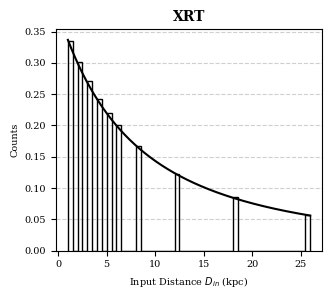

0.3366872029964435575344339213188504800200462341308593750000000000000000000000000000000000000000000000
5.996777956988895
5.996777956988896
1.0


In [ ]:


# def power_law_tail_re_normalize(x,d):
#     return d*pareto.pdf(x, b=0.78695212, loc=-12.87647158)

# n, bins,_ = plt.hist(tight_distances, bins= 50, edgecolor='black',density = False,histtype="step")

# n = n[n>0]

# popt, pcov = curve_fit(power_law_tail_re_normalize, [1, 2, 3, 4, 5, 6, 8, 12, 18, 26], n,p0=1, maxfev=10000)

# density = power_law_tail_re_normalize(distances_plot,*popt)
density = best_function(distances_plot,*best_fit_param_list[mse_list.argmin()])

# Create the histogram
fig, ax = plt.subplots(figsize=(10/3, 3))  # Suitable for single-column MNRAS format
plt.plot(distances_plot,density,"k-",label="Best-fit")
ax.hist(tight_distances, bins=50, edgecolor='black',color='#4d4d4d',density=True,histtype="step")

# Set labels and title with LaTeX formatting
ax.set_xlabel(r'Input Distance $D_{in}$ (kpc)', fontsize=7)
ax.set_ylabel('Counts', fontsize=7)
# ax.set_title('Stacked Histogram of Distances', fontsize=14)

ax.set_title(f"{instr.upper()}", fontsize=10, fontweight='bold')

# Add a grid with dashed lines
ax.grid(axis='y', linestyle='--', alpha=0.6)

# # Add a legend
# ax.legend()

# Adjust layout for clarity
plt.tight_layout()

# Save the figure in a high-resolution format suitable for publication
plt.savefig(f'plots/{instr}/constrained_distances_{instr}_density.pdf', dpi=600)

# Show the plot
plt.show()

print('%.100f' % best_function(1,*best_fit_param_list[mse_list.argmin()]))

density_normalized = density/(density.sum()*(distances_plot[1]-distances_plot[0]))
# plt.plot(distances_plot,best_function(distances_plot,*best_fit_param_list[mse_list.argmin()]),"r-",label="Nomalized Best-fit")
# plt.show()

print(density[1]/density[-1])
print(density_normalized[1]/density_normalized[-1])
print(density_normalized.sum()*(distances_plot[1]-distances_plot[0]))

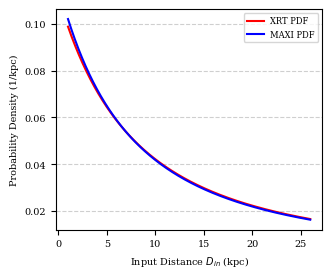

In [ ]:
fig, ax = plt.subplots(figsize=(10/3, 2.8))  # Suitable for single-column MNRAS format
xrt_pareto = pareto.pdf(distances_plot,b=0.87459691,loc=-14.62061867)
maxi_pareto = pareto.pdf(distances_plot,b=0.78695212,loc=-12.87647158)
xrt_pareto = xrt_pareto/(xrt_pareto.sum()*(distances_plot[1]-distances_plot[0]))
maxi_pareto = maxi_pareto/(maxi_pareto.sum()*(distances_plot[1]-distances_plot[0]))

plt.plot(distances_plot,xrt_pareto,"r-",label="XRT PDF")
plt.plot(distances_plot,maxi_pareto,"b-",label="MAXI PDF")

# Set labels and title with LaTeX formatting
ax.set_xlabel(r'Input Distance $D_{in}$ (kpc)', fontsize=7)
ax.set_ylabel('Probability Density (1/kpc)', fontsize=7)
# ax.set_title('Stacked Histogram of Distances', fontsize=14)

# Add a grid with dashed lines
ax.grid(axis='y', linestyle='--', alpha=0.6)
# Add a legend
ax.legend()
# ax.set_yscale('log')
# ax.set_xscale('log')

# Adjust layout for clarity
plt.tight_layout()

# Save the figure in a high-resolution format suitable for publication
plt.savefig(f'plots/PDF_compare_both.pdf', dpi=600)

# Show the plot
plt.show()

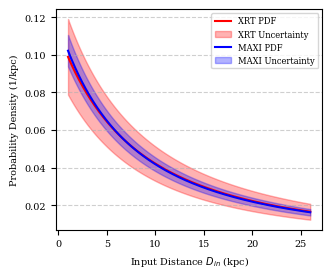

Integrated XRT PDF area: 1.0
Integrated MAXI PDF area: 1.0


In [ ]:
# %% [Cell 3]
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pareto

# Define functions for the Pareto PDFs.
def xrt_pareto_func(x, b, loc):
    return pareto.pdf(x, b=b, loc=loc)

def maxi_pareto_func(x, b, loc):
    return pareto.pdf(x, b=b, loc=loc)

# --------------------------------------------------------------------
# Nominal parameters and assumed uncertainties (adjust as needed)
# --------------------------------------------------------------------
# XRT parameters
b_xrt   = 0.87459691
loc_xrt = -14.62061867
err_b_xrt   = 0.098   # assumed uncertainty for b_xrt
err_loc_xrt = 1.075    # assumed uncertainty for loc_xrt

# MAXI parameters
b_maxi   = 0.78695212
loc_maxi = -12.87647158
err_b_maxi   = 0.043   # assumed uncertainty for b_maxi
err_loc_maxi = 0.45    # assumed uncertainty for loc_maxi

# --------------------------------------------------------------------
# Compute the raw PDF values and their uncertainties using the propagate_errors function.
# (propagate_errors was defined in Cell 1)
# --------------------------------------------------------------------
xrt_pdf_raw = xrt_pareto_func(distances_plot, b_xrt, loc_xrt)
maxi_pdf_raw = maxi_pareto_func(distances_plot, b_maxi, loc_maxi)

# Propagate errors for each PDF.
# The perr vectors correspond to the uncertainties in [b, loc].
xrt_pdf_err_raw  = propagate_errors(distances_plot, xrt_pareto_func, [b_xrt, loc_xrt], [err_b_xrt, err_loc_xrt])
maxi_pdf_err_raw = propagate_errors(distances_plot, maxi_pareto_func, [b_maxi, loc_maxi], [err_b_maxi, err_loc_maxi])

# --------------------------------------------------------------------
# Normalize the PDFs so that the area under each curve equals 1.
# --------------------------------------------------------------------
dx = distances_plot[1] - distances_plot[0]  # step size
xrt_norm  = xrt_pdf_raw.sum()  * dx
maxi_norm = maxi_pdf_raw.sum() * dx

xrt_pdf  = xrt_pdf_raw  / xrt_norm
maxi_pdf = maxi_pdf_raw / maxi_norm

# Normalize the uncertainties by the same factor.
xrt_pdf_err  = xrt_pdf_err_raw  / xrt_norm
maxi_pdf_err = maxi_pdf_err_raw / maxi_norm

# --------------------------------------------------------------------
# Plot the PDFs and their uncertainty bands.
# --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10/3, 2.8))

# Plot XRT PDF and its uncertainty band.
ax.plot(distances_plot, xrt_pdf, "r-", label="XRT PDF")
ax.fill_between(distances_plot, xrt_pdf - xrt_pdf_err, xrt_pdf + xrt_pdf_err,
                color='r', alpha=0.3, label="XRT Uncertainty")

# Plot MAXI PDF and its uncertainty band.
ax.plot(distances_plot, maxi_pdf, "b-", label="MAXI PDF")
ax.fill_between(distances_plot, maxi_pdf - maxi_pdf_err, maxi_pdf + maxi_pdf_err,
                color='b', alpha=0.3, label="MAXI Uncertainty")

ax.set_xlabel(r'Input Distance $D_{in}$ (kpc)', fontsize=7)
ax.set_ylabel('Probability Density (1/kpc)', fontsize=7)
# ax.set_title("PDF Comparison with Uncertainty Bands", fontsize=10, fontweight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.savefig('plots/PDF_compare_both_with_uncertainty.pdf', dpi=600)
plt.show()

# Print integrated areas (should be ~1) for verification.
print("Integrated XRT PDF area:", xrt_pdf.sum() * dx)
print("Integrated MAXI PDF area:", maxi_pdf.sum() * dx)


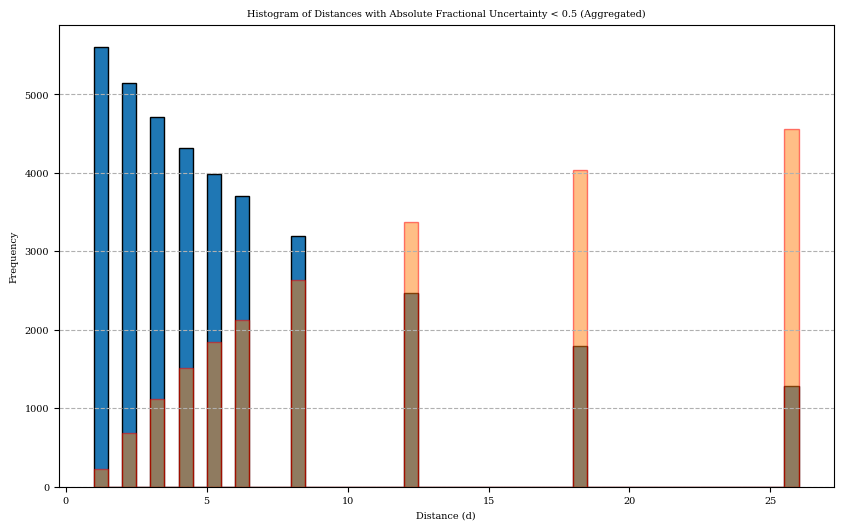

In [ ]:
# Plot the histogram of the aggregated distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, edgecolor='black')
plt.hist(na_distances, bins=50, edgecolor='red', alpha=0.5, label='Non-Available Distances')
plt.xlabel('Distance (d)')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
plt.grid(axis='y', linestyle='--')
plt.show()

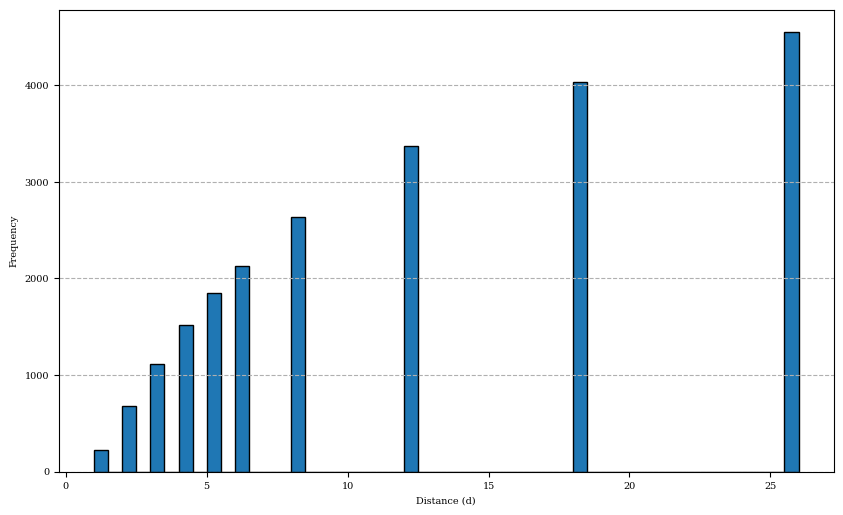

In [ ]:
# Plot the histogram of the aggregated distances
plt.figure(figsize=(10, 6))
plt.hist(na_distances, bins=50, edgecolor='black')
plt.xlabel('Distance (d)')
plt.ylabel('Frequency')
# plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
plt.grid(axis='y', linestyle='--')
plt.show()

# nH-D overview

/tmp/ipykernel_1230035/1949793344.py:4: FutureWarning: The provided callable <function median at 0x7f3a1067df80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  heatmap_data = aggregated_data.pivot_table(index='nH', columns='d', values=central_value, aggfunc=np.median)


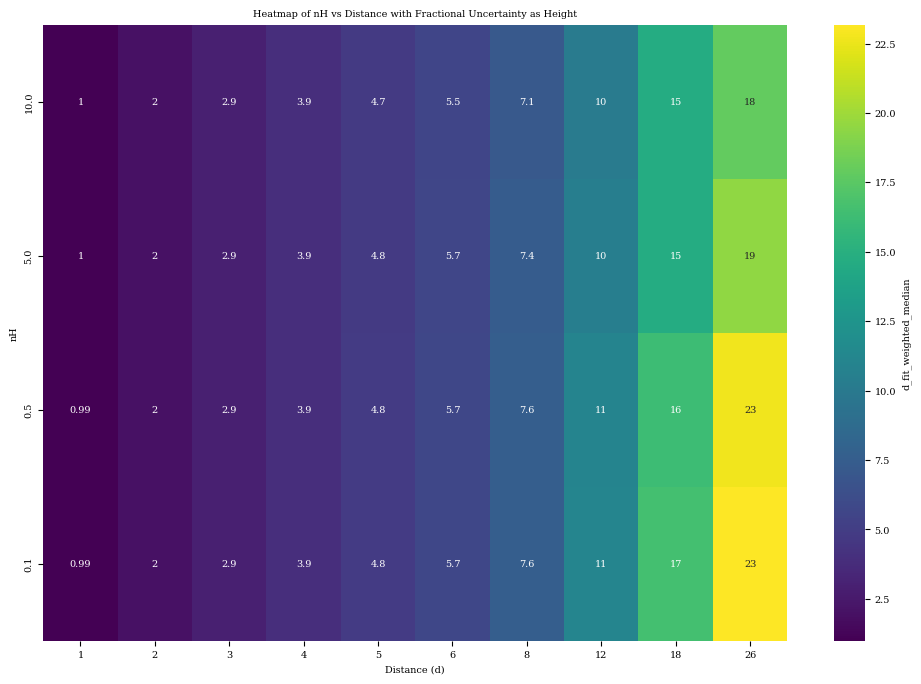

In [ ]:
import seaborn as sns

# Create a pivot table for the heatmap
heatmap_data = aggregated_data.pivot_table(index='nH', columns='d', values=central_value, aggfunc=np.median)

# Sort the index (nH) in ascending order
heatmap_data = heatmap_data.sort_index(ascending=False)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, cbar_kws={'label': central_value})
plt.xlabel('Distance (d)') 
plt.ylabel('nH')
plt.title('Heatmap of nH vs Distance with Fractional Uncertainty as Height')
plt.show()


# nH by distance grid plot

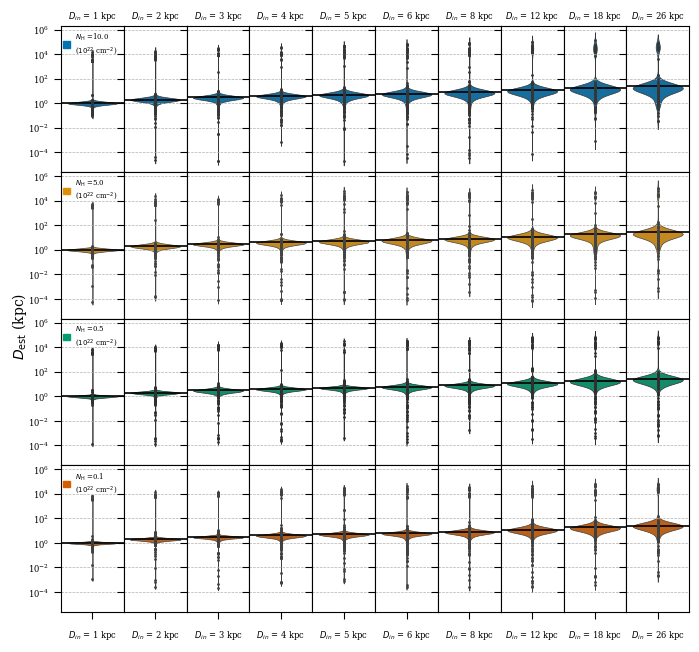

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Group the data by 'nH' and 'd'
grouped_data = aggregated_data.groupby(['nH', 'd'])

# Define unique values of nH and d for the grid layout
nH_values = sorted(aggregated_data['nH'].unique(), reverse=True) 
d_values = sorted(aggregated_data['d'].unique())

# Create a color palette for nH values
palette = sns.color_palette("colorblind", len(nH_values))  # Adjust palette as needed
nH_colors = {nH: color for nH, color in zip(nH_values, palette)}

# Adjust figure size to fit MNRAS page dimensions
fig_width = 6.974  # MNRAS page width in inches
fig_height_per_row = 1.8  # Adjusted height per row
fig_height = fig_height_per_row * len(nH_values)

fig, axes = plt.subplots(
    len(nH_values), len(d_values),
    figsize=(fig_width, fig_height),
    sharex=True, sharey=True,  # Share x and y axes
    gridspec_kw={'wspace': 0, 'hspace': 0}  # Overlap axes
)

# Get global y-axis limits
all_d_fit_values = aggregated_data[central_value]
# ymin, ymax = all_d_fit_values.min(), all_d_fit_values.max()

# Iterate through each nH and d to plot the distribution at each grid cell
for i, nH in enumerate(nH_values):
    for j, d in enumerate(d_values):
        ax = axes[i, j]

        # Get the distribution of d_fit for each combination of nH and d
        subset = grouped_data.get_group((nH, d))[central_value] if (nH, d) in grouped_data.groups else []
        
        ax.set_yscale('log')
        
        if len(subset) > 0:
            sns.violinplot(y=subset, ax=ax, inner="point",color=nH_colors[nH], linewidth=0.5)  # Use the color for the current nH)
        
        # Reduce grid lines to only major ticks on the y-axis
        ax.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5)

        # Set consistent y-axis limits
        # ax.set_ylim(ymin, ymax)

        # Remove the default y-label
        ax.set_ylabel("")

        # Horizontal line for reference
        ax.axhline(y=d_values[j], color="black", linestyle='-', linewidth=1.2)

        # Set titles and labels
        if i == 0:
            ax.set_title(r"$D_{in}$ =" + f" {d} kpc", fontsize=6, pad=5)  # Font size adjusted
        # if j == 0:
        #     ax.set_ylabel(f"$N_H = {nH}$", fontsize=7, labelpad=2)  # Reduced padding

        if j == 0:  # Only add label once per row
            # ax.text(0.05, 0.95, f"Input $N_H$ = {nH}", transform=ax.transAxes,
                    # fontsize=5, verticalalignment='top', horizontalalignment='left',
                    # bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', linewidth=0.3))

            # Add a small legend inside the "Input $N_H$" box
            legend_handle = mpatches.Patch(color=nH_colors[nH], label=r"$N_\text{H}$ =" + f"{nH}\n" + r"($10^{22}$ cm$^{-2}$)")
            ax.legend(
                handles=[legend_handle],
                loc='upper right',
                fontsize=5,
                frameon=False,
                handlelength=1,
                handleheight=1
            )
            
        # Add x-axis labels for the bottom row
        if i == len(nH_values) - 1:
            ax.set_xlabel(r"$D_{in}$ =" + f" {d} kpc", fontsize=6)
            ax.tick_params(axis='x', rotation=45)  # Rotate x-labels

        # Customize ticks
        ax.tick_params(axis='both', which='major', labelsize=6, length=5, width=0.8)
        ax.tick_params(axis='both', which='minor', labelsize=6, length=3, width=0.5)

# Shared ylabel positioned closer to the subplots
fig.text(0.015, 0.5,r"$D_{\text{est}}$ (kpc)", va='center', rotation='vertical', fontsize=10)

# Adjust layout to ensure no text overlap
plt.tight_layout(pad=0.8, rect=[0.03, 0.05, 1, 0.95])

# Save the figure as a high-resolution PDF
plt.savefig(f"plots/{instr}/2d_violin_plot_{instr}.png", dpi=600, bbox_inches='tight')
plt.show()


# Main effect plots

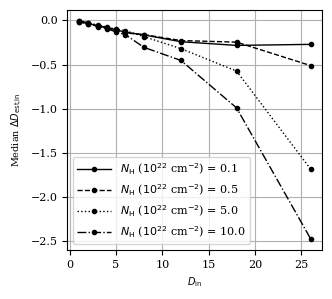

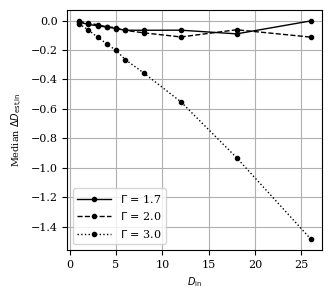

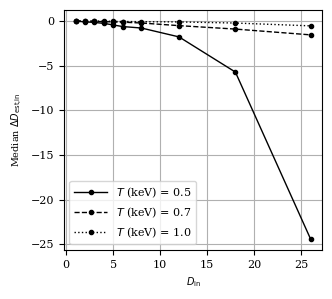

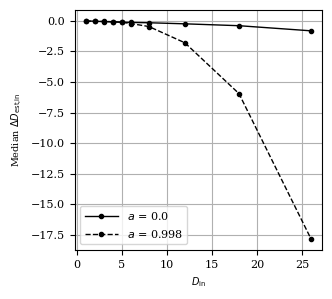

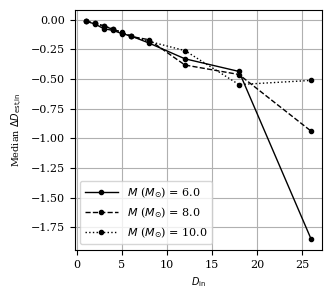

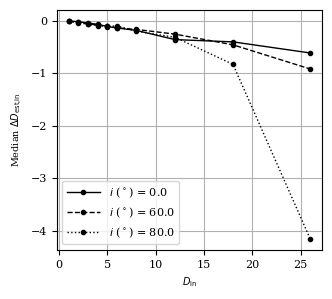

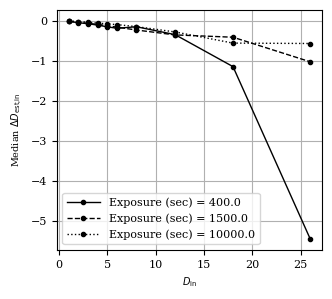

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


plt.rcParams['xtick.labelsize'] = 8  # Set x-axis tick font size
plt.rcParams['ytick.labelsize'] = 8  # Set y-axis tick font size
# plt.rcParams['font.family'] = 'serif' # Set font family, e.g., 'serif', 'sans-serif', 'monospace'
# plt.rcParams['font.serif'] = ['Times New Roman'] # Set specific serif font

# Define the parameter labels with proper LaTeX formatting and units
parameter_labels = {
    'g': r"$\Gamma$",                        # Gamma (no unit label)
    'T': r"$T$ (keV)",                       # Temperature in keV
    'a': r"$a$",                              # Spin parameter (no unit label)
    'm': r"$M$ ($M_{\odot}$)",               # Mass in solar masses
    'i': r"$i$ ($^\circ$)",                   # Inclination in degrees
    'r': r"Disk-to-total ratio",             # Disk to total ratio (no unit label)
    'e': r"Exposure (sec)",                   # Exposure in seconds
    'nH': r"$N_\text{H}$ ($10^{22}$ cm$^{-2}$)"
}


# # Step 1: Attach parameters to each entry in all_data using all_data_params
# all_data_with_params = []
# for data_df, params in zip(all_data, all_data_params):  # Match each dataset with its parameters
#     # Repeat the parameter dictionary for each row in the corresponding data_df
#     params_df = pd.DataFrame([params] * len(data_df))
#     # Concatenate data and parameters
#     data_with_params = pd.concat([data_df.reset_index(drop=True), params_df.reset_index(drop=True)], axis=1)
#     all_data_with_params.append(data_with_params)

# # Step 2: Concatenate all entries into a single DataFrame
# all_data_flat = pd.concat(all_data_with_params, ignore_index=True)

all_data_flat = aggregated_data

# Define the parameters to aggregate by
parameters = ['nH','g', 'T', 'a', 'm', 'i', 'e']
linestyles = ["-", "--", ":", "-."]
colors = ['black','black','black','black']

# Step 3: Loop through each parameter and create violin plots
for param in parameters:
    plt.figure(figsize=(10/3, 3))
    # Get unique values for the current parameter and distance
    param_values = sorted(all_data_flat[param].unique())
    for i,val in enumerate(param_values):
        d_values = sorted(all_data_flat['d'].unique())
        subset = all_data_flat.loc[all_data_flat[param] == val].copy()
        grouped_set = subset.groupby(['d']).median()
        grouped_set_q1 = subset.groupby(['d']).quantile(0.16)
        grouped_set_q2 = subset.groupby(['d']).quantile(0.84)
        # Calculate errors for the error bars
        lower_errors = grouped_set['diff_d'] - grouped_set_q1['diff_d']
        upper_errors = grouped_set_q2['diff_d'] - grouped_set['diff_d']
        asymmetric_errors = [lower_errors, upper_errors]  # For errorbar
        plt.errorbar(d_values, grouped_set['diff_d'], fmt='o',capsize=5, label=f"{parameter_labels[param]} = {val}",linewidth=1, markersize = 3,linestyle=linestyles[i],color=colors[i]) #fmt='o-' creates a line with markers

    plt.xlabel(r"$D_{\text{in}}$")
    plt.ylabel(r"Median $\Delta D_{\text{est,in}}$")
    # plt.title(f"Error Plot for {parameter_labels[param]}")
    plt.legend(fontsize=8,handlelength=3)
    plt.grid(True)
    # Adjust layout for clarity
    plt.tight_layout()
    # plt.savefig(f"plots/{instr}/{param}_trendline_{instr}.png", dpi=600, bbox_inches='tight')
    plt.show()
    

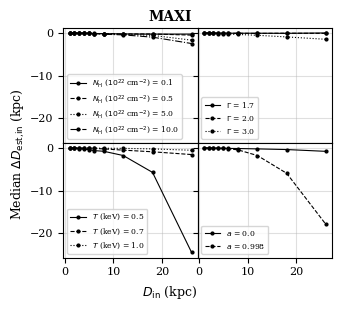

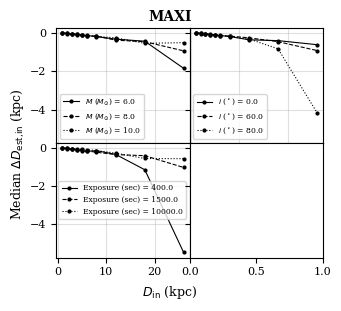

In [10]:
# Set up figure parameters
fig_width = 10/3  # Total figure width in inches
row_height = 1.5  # Height per row in inches
n_cols = 2        # Number of columns per row
n_rows = 2        # Number of rows per figure

# Split parameters into two groups for two figures
parameter_groups = [parameters[:4], parameters[4:]]  # First 4 and last 4 parameters

for fig_num, param_group in enumerate(parameter_groups):
    # Create figure with minimal spacing between subplots
    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(fig_width, n_rows * row_height),
        sharey=True,
        gridspec_kw={'hspace': 0, 'wspace': 0}  # zero spacing in grid
    )
    axs = axs.ravel()

    # Global font sizes (sometimes better to do before creating figure)
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams['legend.fontsize'] = 8

    for i, param in enumerate(param_group):
        ax = axs[i]
        param_values = sorted(all_data_flat[param].unique())

        # Plot lines
        for j, val in enumerate(param_values):
            d_values = sorted(all_data_flat['d'].unique())
            subset = all_data_flat.loc[all_data_flat[param] == val].copy()
            grouped_set = subset.groupby(['d']).median()
            grouped_set_q1 = subset.groupby(['d']).quantile(0.16)
            grouped_set_q2 = subset.groupby(['d']).quantile(0.84)

            lower_errors = grouped_set['diff_d'] - grouped_set_q1['diff_d']
            upper_errors = grouped_set_q2['diff_d'] - grouped_set['diff_d']

            ax.errorbar(
                d_values,
                grouped_set['diff_d'],
                fmt='o',
                capsize=3,
                linewidth=0.8,
                markersize=2,
                linestyle=linestyles[j],
                color=colors[j],
                label=f"{parameter_labels[param]} = {val}"
            )

        # Remove repeated labels from individual subplots
        ax.set_xlabel('')
        ax.set_ylabel('')
        if (i // n_cols) < (n_rows - 1):  # Check if not in bottom row
            ax.tick_params(axis='x', labelbottom=False)  # Hide x-axis tick labels but keep tick markers
        else:
            ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(True, alpha=0.4)
        ax.legend(loc='best', fontsize=5.5, framealpha=0.8)

        # Example: add instrument label to the 2nd subplot (i=1)
        # if i == 1:
        #     ax.text(
        #         0.05, 0.6, f"{instr.upper()}",
        #         transform=ax.transAxes,
        #         fontsize=8,
        #         verticalalignment='top',
        #         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        #     )

    # Figure-level title (call this before tight_layout)
    fig.suptitle(f"{instr.upper()}", 
                 fontsize=10, 
                 fontweight='bold', 
                 x=0.5,       # center horizontally
                 y=0.98) 


    # Figure-level X and Y labels
    # Optional: adjust x= or y= if you find the labels get cut or have too much space
    fig.supxlabel(r"$D_{\text{in}}$ (kpc)", fontsize=9)
    fig.supylabel(r"Median $\Delta D_{\text{est,in}}$ (kpc)", fontsize=9)

    # First, call tight_layout with reduced padding
    # 'pad' controls the overall padding
    # 'rect' can be used to manually define [left, bottom, right, top] for layout
    plt.tight_layout(pad=0.5, w_pad=0, h_pad=0, rect=[0, 0, 1, 1])

    # If still needed, you can do a further subplots_adjust to reduce any leftover whitespace.
    # For example:
    # fig.subplots_adjust(left=0.08, right=0.98, top=0.95, bottom=0.08)



    # Save figure
    # fig.savefig(
    #     f"plots/{instr}/combined_main_effects_figure_{fig_num+1}_{instr}.png",
    #     dpi=600,
    #     bbox_inches='tight'
    # )
    plt.show()
    plt.close()


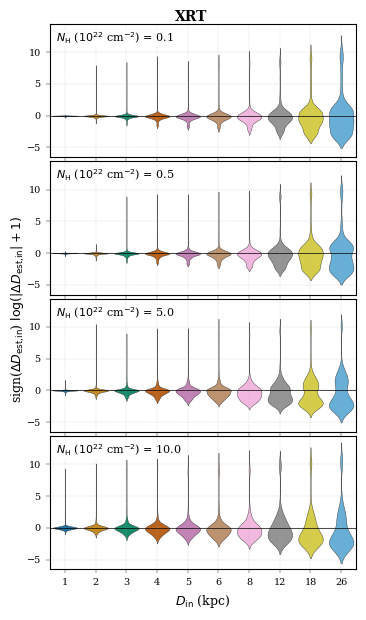

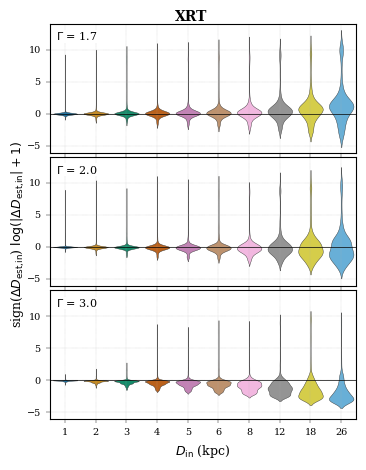

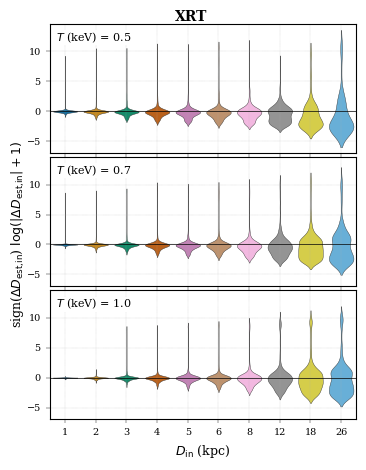

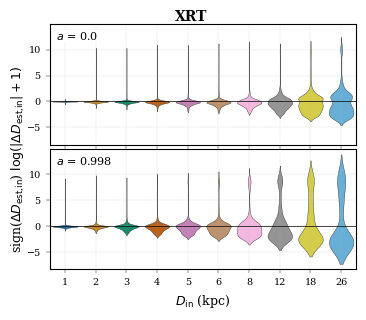

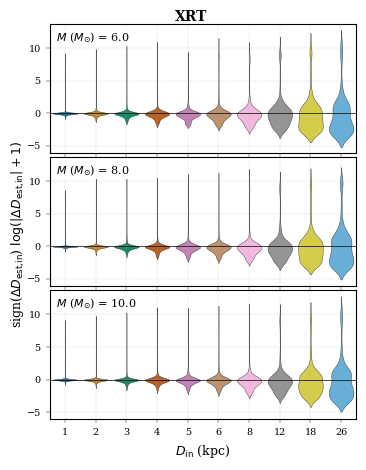

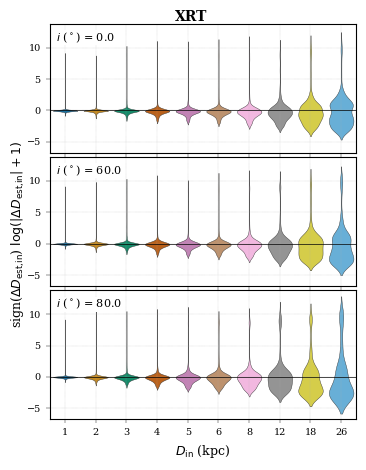

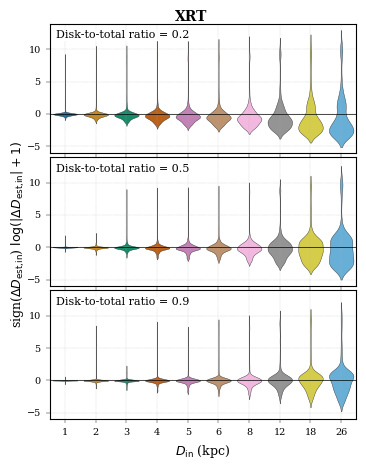

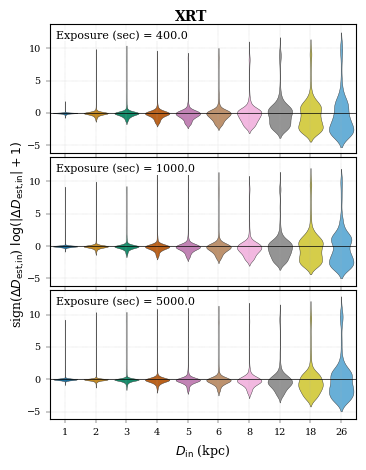

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Define the parameter labels with proper LaTeX formatting and units
parameter_labels = {
    'g': r"$\Gamma$",                        # Gamma (no unit label)
    'T': r"$T$ (keV)",                       # Temperature in keV
    'a': r"$a$",                              # Spin parameter (no unit label)
    'm': r"$M$ ($M_{\odot}$)",               # Mass in solar masses
    'i': r"$i$ ($^\circ$)",                   # Inclination in degrees
    'r': r"Disk-to-total ratio",             # Disk to total ratio (no unit label)
    'e': r"Exposure (sec)",                  # Exposure in seconds
    'nH': r"$N_\text{H}$ ($10^{22}$ cm$^{-2}$)"
}

# # Step 1: Attach parameters to each entry in all_data using all_data_params
# all_data_with_params = []
# for data_df, params in zip(all_data, all_data_params):  # Match each dataset with its parameters
#     # Repeat the parameter dictionary for each row in the corresponding data_df
#     params_df = pd.DataFrame([params] * len(data_df))
#     # Concatenate data and parameters
#     data_with_params = pd.concat([data_df.reset_index(drop=True), params_df.reset_index(drop=True)], axis=1)
#     all_data_with_params.append(data_with_params)
    
# # Step 2: Concatenate all entries into a single DataFrame
# all_data_flat = pd.concat(all_data_with_params, ignore_index=True)
# all_data_flat['diff_d'] = all_data_flat['d_fit_weighted_median'] - all_data_flat['d']

# Define the parameters to aggregate by
parameters = ['nH','g', 'T', 'a', 'm', 'i', 'r', 'e']

# Step 3: Loop through each parameter and create violin plots
for param in parameters:
    # Get unique values for the current parameter and distance
    param_values = sorted(all_data_flat[param].unique())
    d_values = sorted(all_data_flat['d'].unique())

    if param == 'g' or param == 'm':
        
        # Create subplots for the current parameter
        fig, axes = plt.subplots(
            len(param_values), 1,
            figsize=(3.3, len(param_values) * 1.5),  # Single-column layout
            sharex=True,
            sharey=True
        )
    else:
        # Create subplots for the current parameter
        fig, axes = plt.subplots(
            len(param_values), 1,
            figsize=(3.3, len(param_values) * 1.5),  # Single-column layout
            sharex=True,
            sharey=True
        )

    # Set vertical spacing between subplots to zero
    plt.subplots_adjust(hspace=0)  # No vertical space between panels

    # Iterate through each parameter value and plot distributions
    for i, (ax, val) in enumerate(zip(axes, param_values)):
        # Filter the data for the current parameter value
        subset = all_data_flat.loc[all_data_flat[param] == val].copy()

        if not subset.empty:
            # subset['d'] = subset['d'].astype(str)  # Convert 'd' to string for categorical x-axis
            subset['logmod_diff_d'] = np.sign(subset['diff_d'].dropna()) * np.log(np.abs(subset['diff_d'].dropna())+1)
            # ax.set_yscale('log')  # Use log scale for y-axis
            palette = sns.color_palette('colorblind', len(d_values))  # Colorblind-friendly palette
            sns.violinplot(
                data=subset,
                x='d',
                y='logmod_diff_d',
                ax=ax,
                hue='d',  # Assign hue to the same as x-axis
                inner=None,  # No internal marks
                palette=palette,
                linewidth=0.3,  # Reduced line width for clarity
                legend=False  # Suppress legend
            )

            # Dynamically calculate the true x-axis limits after padding
            x_limits = ax.get_xlim()
            x_left = x_limits[0]  # True left edge of the axis
            for d_idx, d_value in enumerate(d_values):
                # Get subset of data for the current `d_value`
                data_d_value = subset.loc[subset['d'] == str(d_value), central_value]
                if not data_d_value.empty:
                    x_max = d_idx + 0.3  # Slightly after the violin's center
                    # ax.plot([x_left, x_max], [d_value, d_value], color=palette[d_idx], linestyle='-', linewidth=0.5)
        
        ax.plot([x_limits[0], x_limits[1]], [0, 0], color='black', linestyle='-', linewidth=0.5)

        # Add titles inside the panel using parameter_labels
        ax.text(
            0.02, 0.95, f"{parameter_labels[param]} = {val}",
            transform=ax.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='none', pad=0.2)
        )

        # Add y-axis label for each subplot
        # ax.set_ylabel(r"$D_{\text{est}}$ (kpc)", fontsize=7, labelpad=2)
        # ax.set_ylabel(r"sign($\Delta D_{\text{est,in}}$) $\log(|\Delta D_{\text{est,in}}|+1)$", fontsize=7, labelpad=2)
        ax.set_ylabel("")

        # Add grid lines for better readability
        ax.grid(True, which='major', linestyle=':', linewidth=0.3)

        # Adjust tick size to match label font size
        ax.tick_params(axis='both', which='major', labelsize=7, length=3, width=0.3)
        ax.tick_params(axis='both', which='minor', labelsize=7, length=2, width=0.3)

        # # Adjust the y-axis ticks explicitly for log scaling
        # ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=5))  # Max 5 major ticks
        # ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs="auto", numticks=10))  # Minor ticks
        ax.set_xlim(x_limits)

    # Add x-axis label only for the bottom plot
    axes[-1].set_xlabel(r"$D_{\text{in}}$ (kpc)", fontsize=9)

    fig.text(-0.05, 0.5, r"sign($\Delta D_{\text{est,in}}$) $\log(|\Delta D_{\text{est,in}}|+1)$", va='center', rotation='vertical', fontsize=9)
       # Figure-level title (call this before tight_layout)
    fig.suptitle(f"{instr.upper()}", 
                 fontsize=10, 
                 fontweight='bold', 
                 x=0.5,       # center horizontally
                 y=1) 

    # Adjust layout to ensure no overlaps and save the figure
    plt.tight_layout(pad=0.0)
    plt.savefig(f"plots/{instr}/{param}_violin_plot_{instr}.png", dpi=600, bbox_inches='tight')
    plt.show()
    plt.close(fig)


# Interaction effects plots


===== Found 11 total interaction CSVs =====
  - T:a from effect_T_a.csv
  - T:r from effect_T_r.csv
  - a:i from effect_a_i.csv
  - g:T from effect_g_T.csv
  - g:a from effect_g_a.csv
  - g:e from effect_g_e.csv
  - g:r from effect_g_r.csv
  - nH:T from effect_nH_T.csv
  - nH:a from effect_nH_a.csv
  - nH:g from effect_nH_g.csv
  - nH:r from effect_nH_r.csv
=== Plotting Group 1 (2 interactions) ===
Plotting: T:a from effect_T_a.csv
   xvar categories sorted: ['0.5', '0.7', '1.0']
   groupvar levels sorted: ['0.0', '0.998']
Plotting: T:r from effect_T_r.csv
   xvar categories sorted: ['0.5', '0.7', '1.0']
   groupvar levels sorted: ['0.2', '0.5', '0.9']


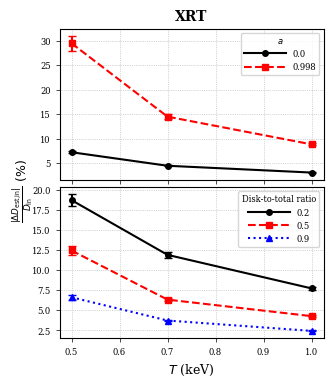

=== Plotting Group 2 (1 interactions) ===
Plotting: a:i from effect_a_i.csv
   xvar categories sorted: ['0.0', '1.0']
   groupvar levels sorted: ['0', '60', '80']


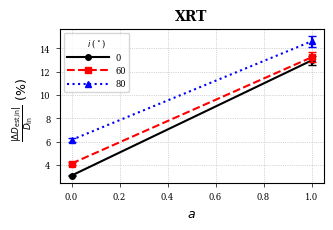

=== Plotting Group 3 (4 interactions) ===
Plotting: g:T from effect_g_T.csv
   xvar categories sorted: ['1.7', '2.0', '3.0']
   groupvar levels sorted: ['0.5', '0.7', '1.0']
Plotting: g:a from effect_g_a.csv
   xvar categories sorted: ['1.7', '2.0', '3.0']
   groupvar levels sorted: ['0.0', '0.998']
Plotting: g:e from effect_g_e.csv
   xvar categories sorted: ['1.7', '2.0', '3.0']
   groupvar levels sorted: ['400', '1000', '5000']
Plotting: g:r from effect_g_r.csv
   xvar categories sorted: ['1.7', '2.0', '3.0']
   groupvar levels sorted: ['0.2', '0.5', '0.9']


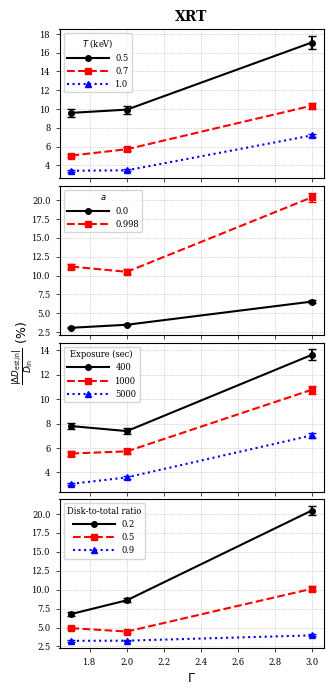

=== Plotting Group 4 (4 interactions) ===
Plotting: nH:T from effect_nH_T.csv
   xvar categories sorted: ['0.1', '0.5', '5.0', '10.0']
   groupvar levels sorted: ['0.5', '0.7', '1.0']
Plotting: nH:a from effect_nH_a.csv
   xvar categories sorted: ['0.1', '0.5', '5.0', '10.0']
   groupvar levels sorted: ['0.0', '0.998']
Plotting: nH:g from effect_nH_g.csv
   xvar categories sorted: ['0.1', '0.5', '5.0', '10.0']
   groupvar levels sorted: ['1.7', '2.0', '3.0']
Plotting: nH:r from effect_nH_r.csv
   xvar categories sorted: ['0.1', '0.5', '5.0', '10.0']
   groupvar levels sorted: ['0.2', '0.5', '0.9']


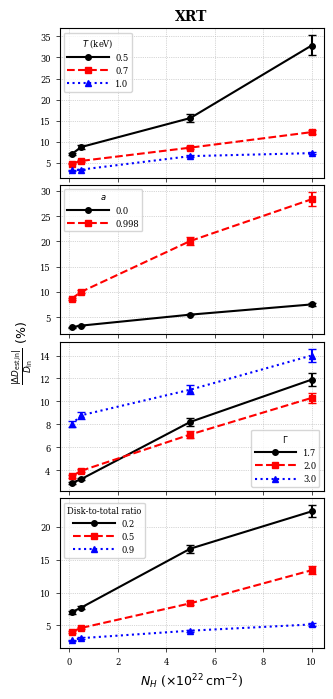

In [ ]:
import glob
from collections import defaultdict
import os
import re

##############################################################################
# 1) Collect all CSV files from "effects_data_{instr}/effect_*.csv"
##############################################################################

instr = 'xrt'

all_csv_files = sorted(glob.glob(f"effects_data_{instr}/effect_*.csv"))

file_effects = []
for csv_file in all_csv_files:
    base_name = os.path.basename(csv_file)
    effect_name = re.sub(r'^effect_|\.csv$', '', base_name)
    # Convert underscores to colons, e.g. "m_r" -> "m:r"
    effect_name = effect_name.replace('_', ':')
    
    file_effects.append((csv_file, effect_name))

n_total = len(file_effects)
print(f"\n===== Found {n_total} total interaction CSVs =====")
for csv_path, eff in file_effects:
    print(f"  - {eff} from {os.path.basename(csv_path)}")

##############################################################################
# 2) Group interactions by the first variable
##############################################################################
grouped_effects = defaultdict(list)
for csv_file, effect_name in file_effects:
    first_var = effect_name.split(':')[0]
    grouped_effects[first_var].append((csv_file, effect_name))

# Convert grouped effects to a list of chunks
chunks = list(grouped_effects.values())

##############################################################################
# 3) Parameter labels (LaTeX-friendly)
##############################################################################
parameter_labels = {
    'g':  r"$\Gamma$",
    'T':  r"$T$ (keV)",
    'a':  r"$a$",
    'm':  r"$m$ ($M_{\odot}$)",
    'i':  r"$i$ ($^\circ$)",
    'r':  r"Disk-to-total ratio",
    'e':  r"Exposure (sec)",
    'd':  r"$D$ (kpc)",
    'nH': r"$N_H$ ($\times 10^{22} \,\mathrm{cm}^{-2}$)"
}

##############################################################################
# 4) Helper: Sort categories numerically if possible
##############################################################################
def sort_as_numeric_if_possible(values):
    """
    Attempt to parse each string in `values` as float.
    If successful, sort numerically. Otherwise, sort lexically.
    Returns a list of sorted strings.
    
    Reference:
    - https://matplotlib.org/stable/tutorials/text/text_intro.html
    """
    unique_vals = list(set(values))
    try:
        float_vals = [float(v) for v in unique_vals]
        float_vals.sort()
        return [str(v) for v in float_vals]
    except ValueError:
        return sorted(unique_vals, key=str)

##############################################################################
# 5) The main plotting function for one interaction
##############################################################################
def plot_interaction(ax, csv_file, effect_name, param_labels):
    print(f"Plotting: {effect_name} from {os.path.basename(csv_file)}")

    vars_in_effect = effect_name.split(':')
    if len(vars_in_effect) != 2:
        print(f"  Skipping: '{effect_name}' does not have exactly 2 vars.")
        ax.set_visible(False)
        return

    xvar, groupvar = vars_in_effect

    # Read CSV
    df = pd.read_csv(csv_file)
    if df.empty:
        print(f"  Skipping: {csv_file} is empty.")
        ax.set_visible(False)
        return

    needed_cols = {xvar, groupvar, "fit", "lower", "upper"}
    if not needed_cols.issubset(df.columns):
        print(f"  Skipping: missing columns. Need {needed_cols}, have {df.columns}")
        ax.set_visible(False)
        return

    # Convert xvar to numeric
    df[xvar] = pd.to_numeric(df[xvar], errors="coerce").round(2)
    df = df.dropna(subset=[xvar])
    if df.empty:
        print(f"  Skipping: all xvar are NaN after conversion.")
        ax.set_visible(False)
        return

    # Sort xvar categories numerically if possible
    xcats = sort_as_numeric_if_possible(df[xvar])
    print(f"   xvar categories sorted: {xcats}")
    if not xcats:
        print("  No valid x categories after conversion.")
        ax.set_visible(False)
        return

    # Sort groupvar levels numerically if possible
    df[groupvar] = df[groupvar].astype(str)
    group_candidates = sorted(set(df[groupvar]))
    try:
        sorted_groups = sorted(group_candidates, key=lambda x: float(x))
    except ValueError:
        sorted_groups = sorted(group_candidates)

    print("   groupvar levels sorted:", sorted_groups)

    # Plot each group with line + error bars
    colors = ['black','red','blue','green']
    linestyles = ["-", "--", ":", "-."]
    markers = ['o', 's', '^', 'x']

    for marker, linestyle, color, grp_value in zip(markers, linestyles, colors, sorted_groups):
        subset = df[df[groupvar] == grp_value]
        ax.plot(
            df[xvar].unique(),
            np.exp(subset["fit"]) * 100,
            marker=marker,
            color=color,
            linestyle=linestyle,
            markersize=4,
            label=grp_value
        )
        ax.errorbar(
            df[xvar].unique(),
            np.exp(subset["fit"]) * 100,
            yerr=[
                (np.exp(subset["fit"]) - np.exp(subset["lower"])) * 100,
                (np.exp(subset["upper"]) - np.exp(subset["fit"])) * 100
            ],
            fmt='none',
            ecolor=color,
            capsize=3,
            label="_nolegend_"
        )

    # Remove the individual x-label to reduce repetition:
    # ax.set_xlabel(param_labels.get(xvar, xvar), fontsize=8)  # <-- commented out
    ax.legend(fontsize=6, title=param_labels.get(groupvar, groupvar), loc="best",
              title_fontsize=6, handlelength=5)
    ax.tick_params(axis='both', which='major', labelsize=6, length=3, width=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)

##############################################################################
# 6) A helper to plot one "chunk" of interactions, single column, no vertical spacing
##############################################################################
def plot_chunk(chunk, figure_index, param_labels):
    n_subplots = len(chunk)
    n_rows = n_subplots
    n_cols = 1

    # Single-column MNRAS figure width ~3.3 to 3.5 inches
    fig_height = 1.8 * n_rows  # Adjust as needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.3, fig_height),
                             sharex=True, sharey=False)

    if n_subplots == 1:
        axes = [axes]

    # Plot the interactions
    for i, (csv_file, effect_name) in enumerate(chunk):
        plot_interaction(axes[i], csv_file, effect_name, param_labels)
        # Hide x-axis labels for all but the bottom subplot
        if i < n_subplots - 1:
            axes[i].tick_params(labelbottom=False)

    # Common y-label
    fig.supylabel(
        r'$\frac{|\Delta D_{\text{est,in}}|}{D_{\text{in}}}\ (\%)$',
        fontsize=9,
        x=0.00
    )

    # Title for top subplot only (similar logic as for x-label in bottom subplot)
    axes[0].set_title(
        f"{instr.upper()}",
        fontsize=10,
        fontweight='bold'
    )

    # Regular x-axis label only on the bottom subplot
    _, example_effect_name = chunk[0]
    xvar_for_chunk = example_effect_name.split(':')[0]
    axes[-1].set_xlabel(param_labels.get(xvar_for_chunk, xvar_for_chunk), fontsize=9)

    # Remove or comment out the figure-level suptitle:
    # fig.suptitle(...)

    plt.tight_layout()
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.09, hspace=0.05)

    out_file = f"plots/{instr}/effects_figure_{figure_index}.png"
    plt.savefig(out_file, dpi=600, bbox_inches="tight")
    plt.show()


##############################################################################
# 7) Plot each group
##############################################################################
for i, chunk in enumerate(chunks, start=1):
    print(f"=== Plotting Group {i} ({len(chunk)} interactions) ===")
    plot_chunk(chunk, i, parameter_labels)



===== Found 13 total interaction CSVs =====
  - T:a from effect_T_a.csv
  - T:e from effect_T_e.csv
  - T:r from effect_T_r.csv
  - a:e from effect_a_e.csv
  - a:i from effect_a_i.csv
  - g:T from effect_g_T.csv
  - g:a from effect_g_a.csv
  - g:e from effect_g_e.csv
  - g:r from effect_g_r.csv
  - nH:T from effect_nH_T.csv
  - nH:a from effect_nH_a.csv
  - nH:g from effect_nH_g.csv
  - nH:r from effect_nH_r.csv
=== Plotting Group 1 even part (2 interactions) ===
Plotting: T:a from effect_T_a.csv
   xvar categories sorted: ['0.5', '0.7', '1.0']
   groupvar levels sorted: ['0.0', '0.998']
Plotting: T:r from effect_T_r.csv
   xvar categories sorted: ['0.5', '0.7', '1.0']
   groupvar levels sorted: ['0.2', '0.5', '0.9']


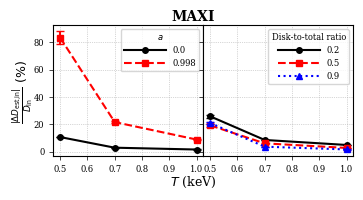

=== Plotting Group 1 separated plot (1 interaction) ===
Plotting: T:e from effect_T_e.csv
   xvar categories sorted: ['0.5', '0.7', '1.0']
   groupvar levels sorted: ['400', '1500', '10000']


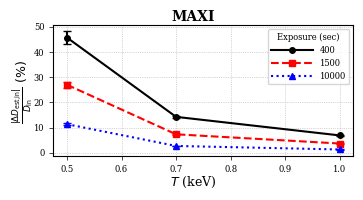

=== Plotting Group 2 even part (1 interactions) ===
Plotting: a:i from effect_a_i.csv
   xvar categories sorted: ['0.0', '1.0']
   groupvar levels sorted: ['0', '60', '80']


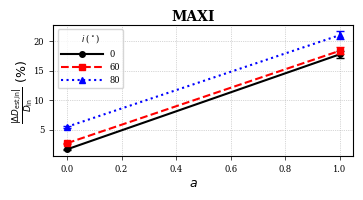

=== Plotting Group 2 separated plot (1 interaction) ===
Plotting: a:e from effect_a_e.csv
   xvar categories sorted: ['0.0', '1.0']
   groupvar levels sorted: ['400', '1500', '10000']


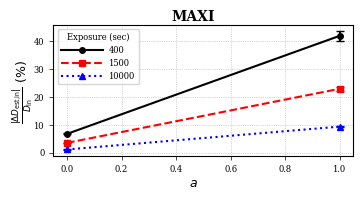

=== Plotting Group 3 (4 interactions) ===
Plotting: g:T from effect_g_T.csv
   xvar categories sorted: ['1.7', '2.0', '3.0']
   groupvar levels sorted: ['0.5', '0.7', '1.0']
Plotting: g:a from effect_g_a.csv
   xvar categories sorted: ['1.7', '2.0', '3.0']
   groupvar levels sorted: ['0.0', '0.998']
Plotting: g:e from effect_g_e.csv
   xvar categories sorted: ['1.7', '2.0', '3.0']
   groupvar levels sorted: ['400', '1500', '10000']
Plotting: g:r from effect_g_r.csv
   xvar categories sorted: ['1.7', '2.0', '3.0']
   groupvar levels sorted: ['0.2', '0.5', '0.9']


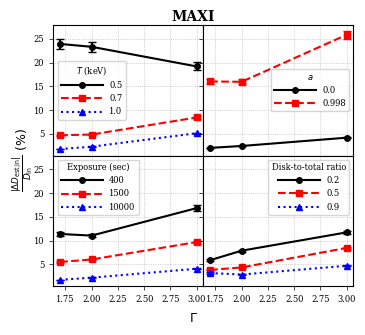

=== Plotting Group 4 (4 interactions) ===
Plotting: nH:T from effect_nH_T.csv
   xvar categories sorted: ['0.1', '0.5', '5.0', '10.0']
   groupvar levels sorted: ['0.5', '0.7', '1.0']
Plotting: nH:a from effect_nH_a.csv
   xvar categories sorted: ['0.1', '0.5', '5.0', '10.0']
   groupvar levels sorted: ['0.0', '0.998']
Plotting: nH:g from effect_nH_g.csv
   xvar categories sorted: ['0.1', '0.5', '5.0', '10.0']
   groupvar levels sorted: ['1.7', '2.0', '3.0']
Plotting: nH:r from effect_nH_r.csv
   xvar categories sorted: ['0.1', '0.5', '5.0', '10.0']
   groupvar levels sorted: ['0.2', '0.5', '0.9']


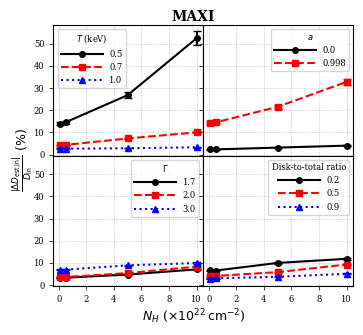

In [ ]:
import glob
from collections import defaultdict
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global font settings (from your sample)
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 8

##############################################################################
# 1) Collect all CSV files from "effects_data_{instr}/effect_*.csv"
##############################################################################
instr = 'maxi'

all_csv_files = sorted(glob.glob(f"effects_data_{instr}/effect_*.csv"))

file_effects = []
for csv_file in all_csv_files:
    base_name = os.path.basename(csv_file)
    effect_name = re.sub(r'^effect_|\.csv$', '', base_name)
    # Convert underscores to colons, e.g. "m_r" -> "m:r"
    effect_name = effect_name.replace('_', ':')
    file_effects.append((csv_file, effect_name))

n_total = len(file_effects)
print(f"\n===== Found {n_total} total interaction CSVs =====")
for csv_path, eff in file_effects:
    print(f"  - {eff} from {os.path.basename(csv_path)}")

##############################################################################
# 2) Group interactions by the first variable
##############################################################################
grouped_effects = defaultdict(list)
for csv_file, effect_name in file_effects:
    first_var = effect_name.split(':')[0]
    grouped_effects[first_var].append((csv_file, effect_name))

# Convert grouped effects to a list of chunks
chunks = list(grouped_effects.values())

##############################################################################
# 3) Parameter labels (LaTeX-friendly)
##############################################################################
parameter_labels = {
    'g':  r"$\Gamma$",
    'T':  r"$T$ (keV)",
    'a':  r"$a$",
    'm':  r"$m$ ($M_{\odot}$)",
    'i':  r"$i$ ($^\circ$)",
    'r':  r"Disk-to-total ratio",
    'e':  r"Exposure (sec)",
    'd':  r"$D$ (kpc)",
    'nH': r"$N_H$ ($\times 10^{22} \,\mathrm{cm}^{-2}$)"
}

##############################################################################
# 4) Helper: Sort categories numerically if possible
##############################################################################
def sort_as_numeric_if_possible(values):
    unique_vals = list(set(values))
    try:
        float_vals = [float(v) for v in unique_vals]
        float_vals.sort()
        return [str(v) for v in float_vals]
    except ValueError:
        return sorted(unique_vals, key=str)

##############################################################################
# 5) The main plotting function for one interaction
##############################################################################
def plot_interaction(ax, csv_file, effect_name, param_labels):
    print(f"Plotting: {effect_name} from {os.path.basename(csv_file)}")
    vars_in_effect = effect_name.split(':')
    if len(vars_in_effect) != 2:
        print(f"  Skipping: '{effect_name}' does not have exactly 2 vars.")
        ax.set_visible(False)
        return

    xvar, groupvar = vars_in_effect

    # Read CSV
    df = pd.read_csv(csv_file)
    if df.empty:
        print(f"  Skipping: {csv_file} is empty.")
        ax.set_visible(False)
        return

    needed_cols = {xvar, groupvar, "fit", "lower", "upper"}
    if not needed_cols.issubset(df.columns):
        print(f"  Skipping: missing columns. Need {needed_cols}, have {df.columns}")
        ax.set_visible(False)
        return

    # Convert xvar to numeric
    df[xvar] = pd.to_numeric(df[xvar], errors="coerce").round(2)
    df = df.dropna(subset=[xvar])
    if df.empty:
        print(f"  Skipping: all xvar are NaN after conversion.")
        ax.set_visible(False)
        return

    # Sort xvar categories numerically if possible
    xcats = sort_as_numeric_if_possible(df[xvar])
    print(f"   xvar categories sorted: {xcats}")
    if not xcats:
        print("  No valid x categories after conversion.")
        ax.set_visible(False)
        return

    # Sort groupvar levels numerically if possible
    df[groupvar] = df[groupvar].astype(str)
    group_candidates = sorted(set(df[groupvar]))
    try:
        sorted_groups = sorted(group_candidates, key=lambda x: float(x))
    except ValueError:
        sorted_groups = sorted(group_candidates)

    print("   groupvar levels sorted:", sorted_groups)

    # Plot each group with line + error bars
    colors = ['black', 'red', 'blue', 'green']
    linestyles = ["-", "--", ":", "-."]
    markers = ['o', 's', '^', 'x']

    for marker, linestyle, color, grp_value in zip(markers, linestyles, colors, sorted_groups):
        subset = df[df[groupvar] == grp_value]
        ax.plot(
            df[xvar].unique(),
            np.exp(subset["fit"]) * 100,
            marker=marker,
            color=color,
            linestyle=linestyle,
            markersize=4,
            label=grp_value
        )
        ax.errorbar(
            df[xvar].unique(),
            np.exp(subset["fit"]) * 100,
            yerr=[
                (np.exp(subset["fit"]) - np.exp(subset["lower"])) * 100,
                (np.exp(subset["upper"]) - np.exp(subset["fit"])) * 100
            ],
            fmt='none',
            ecolor=color,
            capsize=3,
            label="_nolegend_"
        )

    ax.legend(fontsize=6, title=param_labels.get(groupvar, groupvar), loc="best",
              title_fontsize=6, handlelength=5)
    ax.tick_params(axis='both', which='major', labelsize=6, length=3, width=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)

##############################################################################
# 6) A helper to plot one "chunk" of interactions with a grid layout
##############################################################################
def plot_chunk(chunk, figure_index, param_labels):
    n_subplots = len(chunk)
    # If only one subplot, use one column; otherwise use two columns.
    n_cols = 1 if n_subplots == 1 else 2
    n_rows = math.ceil(n_subplots / n_cols)

    # Figure size: for two-column figures we use the sample size; for a single plot,
    # the width remains the same so the plot fills the entire width.
    fig_width = 10/3
    row_height = 1.5
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, n_rows * row_height),
                             sharex=True, sharey=True,
                             gridspec_kw={'hspace': 0, 'wspace': 0})
    # Ensure axes is a 1D list
    if n_subplots == 1:
        axes = [axes]
    else:
        axes = axes.ravel()

    # Plot each interaction into its subplot
    for i, (csv_file, effect_name) in enumerate(chunk):
        ax = axes[i]
        plot_interaction(ax, csv_file, effect_name, param_labels)
        # Hide x-axis tick labels for all subplots not in the bottom row.
        if (i // n_cols) != (n_rows - 1):
            ax.tick_params(axis='x', labelbottom=False)

    # Hide any unused subplots
    for j in range(n_subplots, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5, rect=[0.0, 0.1, 1.0, 0.93])
    fig.subplots_adjust(left=0.08, right=0.98, top=0.95, bottom=0.08)

    # Common labels and title for the figure.
    fig.supylabel(r'$\frac{|\Delta D_{\text{est,in}}|}{D_{\text{in}}}\ (\%)$', fontsize=9, x=-0.05)
    _, example_effect_name = chunk[0]
    xvar_for_chunk = example_effect_name.split(':')[0]
    if n_rows == 1:
        fig.suptitle(f"{instr.upper()}", fontsize=10, fontweight='bold', x=0.5, y=1.05)
        fig.supxlabel(param_labels.get(xvar_for_chunk, xvar_for_chunk), fontsize=9, y=-0.15, x=0.5)
    else:
        fig.suptitle(f"{instr.upper()}", fontsize=10, fontweight='bold', x=0.5, y=1)
        fig.supxlabel(param_labels.get(xvar_for_chunk, xvar_for_chunk), fontsize=9, y=-0.05, x=0.5)

    out_file = f"plots/{instr}/effects_figure_{figure_index}.png"
    plt.savefig(out_file, dpi=600, bbox_inches="tight")
    plt.show()
    plt.close()

##############################################################################
# 7) Plot each group; decide whether to force separation for each chunk.
##############################################################################

# --- New Options ---
# Global options:
force_separation = False     # If True, force separation for all chunks (with >1 interaction)
separation_index_list = [1,0]     # Set to a valid 0-based index to choose which plot to separate (default: last plot)
# Option to select which chunk(s) to force separation for.
# List chunk numbers (starting at 1) for which you want to force separation.
# For example, [2, 4] forces separation only for chunks 2 and 4 (unless force_separation is True globally).
force_separation_chunks = [1,2]  # Leave empty if you don't want to select individual chunks

fig_counter = 1  # Global counter for figure numbering
for i, chunk in enumerate(chunks, start=1):
    # Decide whether to force separation on this chunk.
    separate = False
    if len(chunk) > 1:
        if force_separation:
            separate = True
        elif i in force_separation_chunks:
            separate = True
            separation_index = separation_index_list[i-1]     # Set to a valid 0-based index to choose which plot to separate (default: last plot)
        elif len(chunk) % 2 == 1:
            # Default behavior: if the chunk has an odd number of interactions, separate the default plot.
            separate = True
        else:
            separate = False
    else:
        separate = False

    if separate:
        # Determine which interaction to separate.
        if separation_index is None:
            sep_index = len(chunk) - 1
        else:
            if separation_index < 0 or separation_index >= len(chunk):
                print(f"Invalid separation_index {separation_index} for chunk {i} with length {len(chunk)}. Using default (last element).")
                sep_index = len(chunk) - 1
            else:
                sep_index = separation_index
        # Build the chunks: one with the remaining interactions and one with the separated plot.
        even_chunk = chunk[:sep_index] + chunk[sep_index+1:]
        print(f"=== Plotting Group {i} even part ({len(even_chunk)} interactions) ===")
        plot_chunk(even_chunk, fig_counter, parameter_labels)
        fig_counter += 1

        odd_chunk = [chunk[sep_index]]
        print(f"=== Plotting Group {i} separated plot (1 interaction) ===")
        plot_chunk(odd_chunk, fig_counter, parameter_labels)
        fig_counter += 1
    else:
        print(f"=== Plotting Group {i} ({len(chunk)} interactions) ===")
        plot_chunk(chunk, fig_counter, parameter_labels)
        fig_counter += 1



===== Found 13 total interaction CSVs for MAXI =====
  - T:a from effect_T_a.csv
  - T:e from effect_T_e.csv
  - T:r from effect_T_r.csv
  - a:e from effect_a_e.csv
  - a:i from effect_a_i.csv
  - g:T from effect_g_T.csv
  - g:a from effect_g_a.csv
  - g:e from effect_g_e.csv
  - g:r from effect_g_r.csv
  - nH:T from effect_nH_T.csv
  - nH:a from effect_nH_a.csv
  - nH:g from effect_nH_g.csv
  - nH:r from effect_nH_r.csv

===== Found 11 total interaction CSVs for XRT =====
  - T:a from effect_T_a.csv
  - T:r from effect_T_r.csv
  - a:i from effect_a_i.csv
  - g:T from effect_g_T.csv
  - g:a from effect_g_a.csv
  - g:e from effect_g_e.csv
  - g:r from effect_g_r.csv
  - nH:T from effect_nH_T.csv
  - nH:a from effect_nH_a.csv
  - nH:g from effect_nH_g.csv
  - nH:r from effect_nH_r.csv

===== Total effects across instruments: 24 =====
=== Plotting First Variable Group 'T' with 3 total effects ===
Plotting COMMON effects for first variable 'T' with 2 subplots
Plotting: T:a from MAXI (effe

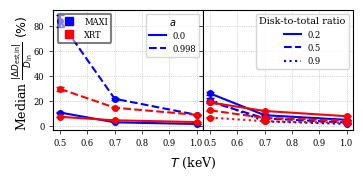

Plotting UNIQUE effects for first variable 'T' with 1 subplots
Plotting: T:e from MAXI (effect_T_e.csv)


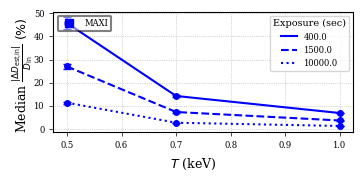

=== Plotting First Variable Group 'a' with 2 total effects ===
Plotting COMMON effects for first variable 'a' with 1 subplots
Plotting: a:i from MAXI (effect_a_i.csv)
Plotting: a:i from XRT (effect_a_i.csv)


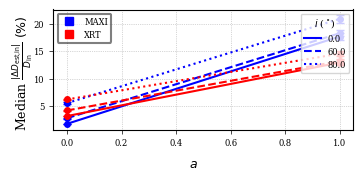

Plotting UNIQUE effects for first variable 'a' with 1 subplots
Plotting: a:e from MAXI (effect_a_e.csv)


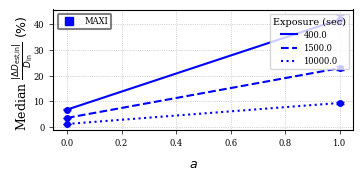

=== Plotting First Variable Group 'g' with 4 total effects ===
Plotting COMMON effects for first variable 'g' with 4 subplots
Plotting: g:T from MAXI (effect_g_T.csv)
Plotting: g:T from XRT (effect_g_T.csv)
Plotting: g:a from MAXI (effect_g_a.csv)
Plotting: g:a from XRT (effect_g_a.csv)
Plotting: g:e from MAXI (effect_g_e.csv)
Plotting: g:e from XRT (effect_g_e.csv)
Plotting: g:r from MAXI (effect_g_r.csv)
Plotting: g:r from XRT (effect_g_r.csv)


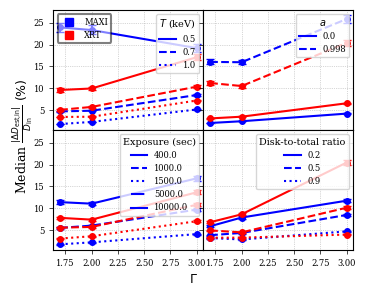

=== Plotting First Variable Group 'nH' with 4 total effects ===
Plotting COMMON effects for first variable 'nH' with 4 subplots
Plotting: nH:T from MAXI (effect_nH_T.csv)
Plotting: nH:T from XRT (effect_nH_T.csv)
Plotting: nH:a from MAXI (effect_nH_a.csv)
Plotting: nH:a from XRT (effect_nH_a.csv)
Plotting: nH:g from MAXI (effect_nH_g.csv)
Plotting: nH:g from XRT (effect_nH_g.csv)
Plotting: nH:r from MAXI (effect_nH_r.csv)
Plotting: nH:r from XRT (effect_nH_r.csv)


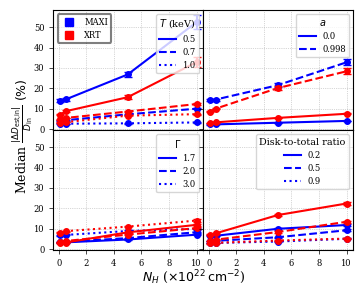

In [ ]:
import glob
from collections import defaultdict
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Global font settings
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 8

##############################################################################
# 1) Load effects from multiple instruments.
##############################################################################
# Define the instruments you want to include.
instruments = ['maxi', 'xrt']  # adjust or add instruments as needed

# List to store effects as tuples: (instrument, csv_file, effect_name)
all_instrument_effects = []

for inst in instruments:
    all_csv_files = sorted(glob.glob(f"effects_data_{inst}/effect_*.csv"))
    print(f"\n===== Found {len(all_csv_files)} total interaction CSVs for {inst.upper()} =====")
    for csv_file in all_csv_files:
        base_name = os.path.basename(csv_file)
        effect_name = re.sub(r'^effect_|\.csv$', '', base_name)
        # Convert underscores to colons, e.g. "m_r" -> "m:r"
        effect_name = effect_name.replace('_', ':')
        print(f"  - {effect_name} from {os.path.basename(csv_file)}")
        all_instrument_effects.append((inst, csv_file, effect_name))

n_total = len(all_instrument_effects)
print(f"\n===== Total effects across instruments: {n_total} =====")

##############################################################################
# 2) Group effects by the first interaction variable.
#
#    We assume each effect string is of the form "first:second".  
#    Here we first cluster by the first variable; within each such group we 
#    further cluster by the full effect string.
##############################################################################
grouped_by_first = defaultdict(lambda: defaultdict(list))
for inst, csv_file, effect_name in all_instrument_effects:
    try:
        first_var, second_var = effect_name.split(':', 1)
    except ValueError:
        continue
    grouped_by_first[first_var][effect_name].append((inst, csv_file, effect_name))

# For each first variable, produce a dictionary whose values are lists of tuples
# (each corresponding to one full effect string).
first_var_groups = {}
for first_var, subdict in grouped_by_first.items():
    # sort the full effect strings so the order is consistent.
    chunks = [subdict[eff_str] for eff_str in sorted(subdict.keys())]
    first_var_groups[first_var] = chunks

##############################################################################
# 3) Parameter labels (LaTeX-friendly)
##############################################################################
parameter_labels = {
    'g':  r"$\Gamma$",
    'T':  r"$T$ (keV)",
    'a':  r"$a$",
    'm':  r"$m$ ($M_{\odot}$)",
    'i':  r"$i$ ($^\circ$)",
    'r':  r"Disk-to-total ratio",
    'e':  r"Exposure (sec)",
    'd':  r"$D$ (kpc)",
    'nH': r"$N_H$ ($\times 10^{22}\,\mathrm{cm}^{-2}$)"
}

##############################################################################
# 4) Define instrument colors (one fixed color per instrument)
##############################################################################
instrument_colors = {
    'maxi': 'blue',
    'xrt': 'red'
    # add more instruments if needed
}

##############################################################################
# 5) Helper: Sort categories numerically if possible.
##############################################################################
def sort_as_numeric_if_possible(values):
    unique_vals = list(set(values))
    try:
        float_vals = [float(v) for v in unique_vals]
        float_vals.sort()
        return [str(v) for v in float_vals]
    except ValueError:
        return sorted(unique_vals, key=str)

##############################################################################
# 5a) Helper: Flatten the axes object.
##############################################################################
def flatten_axes(axes):
    if hasattr(axes, "ravel"):
        return axes.ravel()
    else:
        return [axes]

##############################################################################
# 6) Function to plot one pairwise interaction (one subplot).
#
#    This function overlays all lines (from different instruments) for the
#    same full effect (e.g. "nH:T"). It uses:
#      - The instrument’s fixed color (from instrument_colors)
#      - A cycle of linestyles for the different group levels (the second variable)
#
#    It does not add its own legend.
##############################################################################
def plot_interaction(ax, inst, csv_file, effect_name, param_labels, instrument_colors):
    print(f"Plotting: {effect_name} from {inst.upper()} ({os.path.basename(csv_file)})")
    parts = effect_name.split(':')
    if len(parts) != 2:
        print(f"  Skipping: '{effect_name}' does not have exactly 2 parts.")
        return set()  # Return an empty set if effect_name is not in the expected format.
    xvar, groupvar = parts

    # Read CSV
    df = pd.read_csv(csv_file)
    if df.empty:
        print(f"  Skipping: {csv_file} is empty.")
        return set()

    needed_cols = {xvar, groupvar, "fit", "lower", "upper"}
    if not needed_cols.issubset(df.columns):
        print(f"  Skipping: missing columns in {csv_file}.")
        return set()

    # Convert xvar to numeric and drop NaNs.
    df[xvar] = pd.to_numeric(df[xvar], errors="coerce").round(2)
    df = df.dropna(subset=[xvar])
    if df.empty:
        print(f"  Skipping: all xvar values are NaN in {csv_file}.")
        return set()

    # Determine x-axis categories (sorted numerically if possible).
    xcats = sort_as_numeric_if_possible(df[xvar])
    if not xcats:
        return set()

    # Determine unique levels of the group variable.
    df[groupvar] = df[groupvar].astype(str)
    group_candidates = sorted(set(df[groupvar]))
    try:
        sorted_groups = sorted(group_candidates, key=lambda x: float(x))
    except ValueError:
        sorted_groups = sorted(group_candidates)

    # Use the fixed color for the instrument.
    inst_color = instrument_colors.get(inst, 'black')
    marker = 'o'  # fixed marker for all lines
    linestyles = ["-", "--", ":", "-."]

    # Plot one line (with error bars) for each unique group level.
    for idx, grp_value in enumerate(sorted_groups):
        linestyle = linestyles[idx % len(linestyles)]
        subset = df[df[groupvar] == grp_value]
        ax.plot(
            df[xvar].unique(),
            np.exp(subset["fit"]) * 100,
            marker=marker,
            color=inst_color,
            linestyle=linestyle,
            markersize=4,
            label=f"{inst.upper()} {grp_value}"
        )
        ax.errorbar(
            df[xvar].unique(),
            np.exp(subset["fit"]) * 100,
            yerr=[
                (np.exp(subset["fit"]) - np.exp(subset["lower"])) * 100,
                (np.exp(subset["upper"]) - np.exp(subset["fit"])) * 100
            ],
            fmt='none',
            ecolor=inst_color,
            capsize=3
        )
    ax.tick_params(axis='both', which='major', labelsize=6, length=3, width=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)

    # Return the set of group levels from this CSV.
    return set(sorted_groups)

##############################################################################
# 7) Function to plot one pairwise interaction (one subplot) with custom legends.
#
#    This function calls plot_interaction (to overlay the lines from all instruments)
#    and then adds a custom legend inside the subplot for the group levels.
#    The instrument legend has been removed here.
##############################################################################
def plot_effect_subplot(ax, chunk, param_labels):
    # 'chunk' is a list of tuples (inst, csv_file, effect_name) for the same full effect.
    # Initialize an empty set to hold the union of group levels across instruments.
    union_groups = set()
    for (inst, csv_file, effect_name) in chunk:
        groups = plot_interaction(ax, inst, csv_file, effect_name, param_labels, instrument_colors)
        union_groups.update(groups)
    
    # Now build the custom legend for group levels using the union of groups.
    sorted_groups = sort_as_numeric_if_possible(list(union_groups))
    linestyles = ["-", "--", ":", "-."]
    group_handles = []
    for idx, grp in enumerate(sorted_groups):
        # Here we pick the color from the first instrument in the chunk.
        handle = Line2D([], [], color=instrument_colors.get(chunk[0][0], 'black'),
                        linestyle=linestyles[idx % len(linestyles)], label=str(grp))
        group_handles.append(handle)
    
    # Use the grouping variable name (the second part of the effect string) as the legend title.
    groupvar = chunk[0][2].split(':')[1] if ':' in chunk[0][2] else chunk[0][2]
    group_title = param_labels.get(groupvar, groupvar)
    
    # Add only the group legend here.
    ax.legend(handles=group_handles, title=group_title, fontsize=6, loc='upper right')

##############################################################################
# 8) Function to plot all pairwise interactions for one first-variable group.
#
#    Within a given first-variable group we further separate the full effects into:
#      - Common effects: provided by ≥2 instruments.
#      - Unique effects: provided by only one instrument.
#    Each set is plotted in its own figure using a 2‑column grid with no spacing.
##############################################################################
def plot_first_var_group(first_var, chunks, param_labels, figure_index, spacing=0):
    # Separate chunks into common and unique.
    common_chunks = [chunk for chunk in chunks if len({inst for (inst, _, _) in chunk}) > 1]
    unique_chunks = [chunk for chunk in chunks if len({inst for (inst, _, _) in chunk}) == 1]
    
    def plot_chunks_set(chunks_set, set_label):
        n_plots = len(chunks_set)
        if n_plots == 0:
            return
        # Set number of columns dynamically: use 1 column if only one subplot, else 2.
        n_cols = 1 if n_plots == 1 else 2
        n_rows = math.ceil(n_plots / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10/3, n_rows*1.5),
                                 sharex=True, sharey=True,
                                 gridspec_kw={'hspace': spacing, 'wspace': spacing})
        axes = flatten_axes(axes)
        for i, chunk in enumerate(chunks_set):
            ax = axes[i]
            plot_effect_subplot(ax, chunk, param_labels)
        for j in range(n_plots, len(axes)):
            axes[j].set_visible(False)
        fig.supylabel(r'Median $\frac{|\Delta D_{\text{est,in}}|}{D_{\text{in}}}\ (\%)$', fontsize=9, x=-0.05)
        if n_rows == 1:
            fig.supxlabel(parameter_labels.get(first_var, first_var), fontsize=9, y=-0.15, x=0.5)
        else:
            fig.supxlabel(parameter_labels.get(first_var, first_var), fontsize=9, y=-0.0, x=0.5)
        # Eliminate all space between panels.
        plt.tight_layout(pad=0, w_pad=0, h_pad=0, rect=[0, 0.1, 1, 0.93])
        fig.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.12)
        
        # ----- Add single instrument legend for the figure -----
        all_instruments = set()
        for chunk in chunks_set:
            for (inst, _, _) in chunk:
                all_instruments.add(inst)
        sorted_inst = sorted(all_instruments)
        # Use square markers ("s") instead of circles and remove the legend title.
        inst_handles = [Line2D([], [], color=instrument_colors.get(inst, 'black'),
                               marker='s', linestyle='None', markersize=6, label=inst.upper())
                        for inst in sorted_inst]
        # Create the legend without a title.
        leg = fig.legend(handles=inst_handles, fontsize=6,
                         loc='upper left', bbox_to_anchor=(0.08, 0.92), frameon=True)
        # Customize the legend frame to have a dashed border.
        leg.get_frame().set_linewidth(1.5)
        leg.get_frame().set_linestyle('-')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(0.5)
        # ---------------------------------------------------------
        
        out_file = f"plots/effects_{first_var}_{set_label}_figure_{figure_index}.png"
        plt.savefig(out_file, dpi=600, bbox_inches="tight")
        plt.show()
        plt.close()
    
    fig_idx = figure_index
    if common_chunks:
        print(f"Plotting COMMON effects for first variable '{first_var}' with {len(common_chunks)} subplots")
        plot_chunks_set(common_chunks, "Common")
        fig_idx += 1
    if unique_chunks:
        print(f"Plotting UNIQUE effects for first variable '{first_var}' with {len(unique_chunks)} subplots")
        plot_chunks_set(unique_chunks, "Unique")
        fig_idx += 1
    return fig_idx

##############################################################################
# 9) Iterate through the first-variable groups and produce figures.
##############################################################################
fig_counter = 1
for first_var in sorted(first_var_groups.keys()):
    chunks_for_first = first_var_groups[first_var]  # list of chunks (each chunk = one full effect)
    print(f"=== Plotting First Variable Group '{first_var}' with {len(chunks_for_first)} total effects ===")
    fig_counter = plot_first_var_group(first_var, chunks_for_first, parameter_labels, fig_counter, spacing=0)



===== Found 13 total interaction CSVs for MAXI =====
  - T:a from effect_T_a.csv
  - T:e from effect_T_e.csv
  - T:r from effect_T_r.csv
  - a:e from effect_a_e.csv
  - a:i from effect_a_i.csv
  - g:T from effect_g_T.csv
  - g:a from effect_g_a.csv
  - g:e from effect_g_e.csv
  - g:r from effect_g_r.csv
  - nH:T from effect_nH_T.csv
  - nH:a from effect_nH_a.csv
  - nH:g from effect_nH_g.csv
  - nH:r from effect_nH_r.csv

===== Found 11 total interaction CSVs for XRT =====
  - T:a from effect_T_a.csv
  - T:r from effect_T_r.csv
  - a:i from effect_a_i.csv
  - g:T from effect_g_T.csv
  - g:a from effect_g_a.csv
  - g:e from effect_g_e.csv
  - g:r from effect_g_r.csv
  - nH:T from effect_nH_T.csv
  - nH:a from effect_nH_a.csv
  - nH:g from effect_nH_g.csv
  - nH:r from effect_nH_r.csv

===== Total effects across instruments: 14 =====
=== Plotting First Variable Group 'T' with 2 total effects ===
Plotting COMMON effects for first variable 'T' with 1 subplots
Plotting: T:r from MAXI (effe

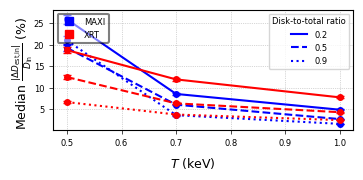

Plotting UNIQUE effects for first variable 'T' with 1 subplots
Plotting: T:e from MAXI (effect_T_e.csv)
Saving as plots/effects_T_Unique_figure_1.png


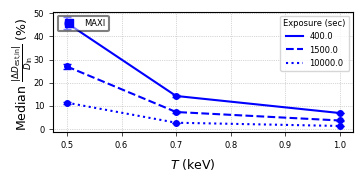

=== Plotting First Variable Group 'a' with 2 total effects ===
Plotting COMMON effects for first variable 'a' with 1 subplots
Plotting: a:i from MAXI (effect_a_i.csv)
Plotting: a:i from XRT (effect_a_i.csv)
Saving as plots/effects_a_Common_figure_3.png


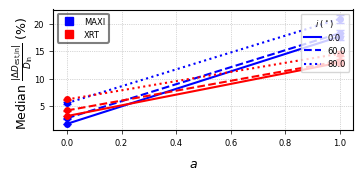

Plotting UNIQUE effects for first variable 'a' with 1 subplots
Plotting: a:e from MAXI (effect_a_e.csv)
Saving as plots/effects_a_Unique_figure_3.png


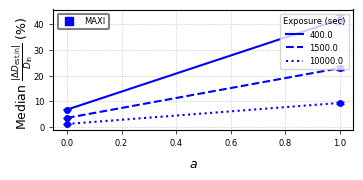

=== Plotting First Variable Group 'g' with 2 total effects ===
Plotting COMMON effects for first variable 'g' with 2 subplots
Plotting: g:a from MAXI (effect_g_a.csv)
Plotting: g:a from XRT (effect_g_a.csv)
Plotting: g:e from MAXI (effect_g_e.csv)
Plotting: g:e from XRT (effect_g_e.csv)
Saving as plots/effects_g_Common_figure_5.png


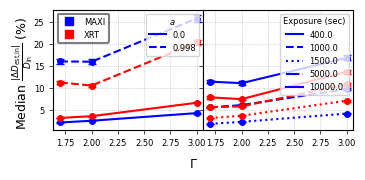

=== Plotting First Variable Group 'nH' with 2 total effects ===
Plotting COMMON effects for first variable 'nH' with 2 subplots
Plotting: nH:a from MAXI (effect_nH_a.csv)
Plotting: nH:a from XRT (effect_nH_a.csv)
Plotting: nH:g from MAXI (effect_nH_g.csv)
Plotting: nH:g from XRT (effect_nH_g.csv)
Saving as plots/effects_nH_Common_figure_6.png


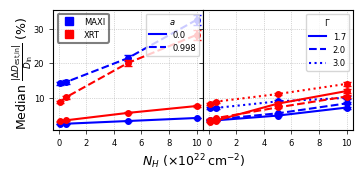

In [ ]:
import glob
from collections import defaultdict
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Global font settings
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 8

##############################################################################
# 1) Load effects from multiple instruments.
##############################################################################
# Define the instruments you want to include.
instruments = ['maxi', 'xrt']  # adjust or add instruments as needed

# List to store effects as tuples: (instrument, csv_file, effect_name)
all_instrument_effects = []

for inst in instruments:
    all_csv_files = sorted(glob.glob(f"effects_data_{inst}/effect_*.csv"))
    print(f"\n===== Found {len(all_csv_files)} total interaction CSVs for {inst.upper()} =====")
    for csv_file in all_csv_files:
        base_name = os.path.basename(csv_file)
        effect_name = re.sub(r'^effect_|\.csv$', '', base_name)
        # Convert underscores to colons, e.g. "m_r" -> "m:r"
        effect_name = effect_name.replace('_', ':')
        print(f"  - {effect_name} from {os.path.basename(csv_file)}")
        all_instrument_effects.append((inst, csv_file, effect_name))

# ------------------------------------------------------
# NEW: Option to plot specific interactions.
# If selected_interactions is empty, all interactions will be plotted.
selected_interactions = ['T:a','g:T','nH:T','g:r','nH:r']  # e.g. ['nH:T', 'm:r']

if selected_interactions:
    all_instrument_effects = [
        (inst, csv_file, effect_name) 
        for (inst, csv_file, effect_name) in all_instrument_effects 
        if effect_name not in selected_interactions
    ]
# ------------------------------------------------------

n_total = len(all_instrument_effects)
print(f"\n===== Total effects across instruments: {n_total} =====")

##############################################################################
# 2) Group effects by the first interaction variable.
#
#    We assume each effect string is of the form "first:second".  
#    Here we first cluster by the first variable; within each such group we 
#    further cluster by the full effect string.
##############################################################################
grouped_by_first = defaultdict(lambda: defaultdict(list))
for inst, csv_file, effect_name in all_instrument_effects:
    try:
        first_var, second_var = effect_name.split(':', 1)
    except ValueError:
        continue
    grouped_by_first[first_var][effect_name].append((inst, csv_file, effect_name))

# For each first variable, produce a dictionary whose values are lists of tuples
# (each corresponding to one full effect string).
first_var_groups = {}
for first_var, subdict in grouped_by_first.items():
    # sort the full effect strings so the order is consistent.
    chunks = [subdict[eff_str] for eff_str in sorted(subdict.keys())]
    first_var_groups[first_var] = chunks

##############################################################################
# 3) Parameter labels (LaTeX-friendly)
##############################################################################
parameter_labels = {
    'g':  r"$\Gamma$",
    'T':  r"$T$ (keV)",
    'a':  r"$a$",
    'm':  r"$m$ ($M_{\odot}$)",
    'i':  r"$i$ ($^\circ$)",
    'r':  r"Disk-to-total ratio",
    'e':  r"Exposure (sec)",
    'd':  r"$D$ (kpc)",
    'nH': r"$N_H$ ($\times 10^{22}\,\mathrm{cm}^{-2}$)"
}

##############################################################################
# 4) Define instrument colors (one fixed color per instrument)
##############################################################################
instrument_colors = {
    'maxi': 'blue',
    'xrt': 'red'
    # add more instruments if needed
}

##############################################################################
# 5) Helper: Sort categories numerically if possible.
##############################################################################
def sort_as_numeric_if_possible(values):
    unique_vals = list(set(values))
    try:
        float_vals = [float(v) for v in unique_vals]
        float_vals.sort()
        return [str(v) for v in float_vals]
    except ValueError:
        return sorted(unique_vals, key=str)

##############################################################################
# 5a) Helper: Flatten the axes object.
##############################################################################
def flatten_axes(axes):
    if hasattr(axes, "ravel"):
        return axes.ravel()
    else:
        return [axes]

##############################################################################
# 6) Function to plot one pairwise interaction (one subplot).
#
#    This function overlays all lines (from different instruments) for the
#    same full effect (e.g. "nH:T"). It uses:
#      - The instrument’s fixed color (from instrument_colors)
#      - A cycle of linestyles for the different group levels (the second variable)
#
#    It does not add its own legend.
##############################################################################
def plot_interaction(ax, inst, csv_file, effect_name, param_labels, instrument_colors):
    print(f"Plotting: {effect_name} from {inst.upper()} ({os.path.basename(csv_file)})")
    parts = effect_name.split(':')
    if len(parts) != 2:
        print(f"  Skipping: '{effect_name}' does not have exactly 2 parts.")
        return set()  # Return an empty set if effect_name is not in the expected format.
    xvar, groupvar = parts

    # Read CSV
    df = pd.read_csv(csv_file)
    if df.empty:
        print(f"  Skipping: {csv_file} is empty.")
        return set()

    needed_cols = {xvar, groupvar, "fit", "lower", "upper"}
    if not needed_cols.issubset(df.columns):
        print(f"  Skipping: missing columns in {csv_file}.")
        return set()

    # Convert xvar to numeric and drop NaNs.
    df[xvar] = pd.to_numeric(df[xvar], errors="coerce").round(2)
    df = df.dropna(subset=[xvar])
    if df.empty:
        print(f"  Skipping: all xvar values are NaN in {csv_file}.")
        return set()

    # Determine x-axis categories (sorted numerically if possible).
    xcats = sort_as_numeric_if_possible(df[xvar])
    if not xcats:
        return set()

    # Determine unique levels of the group variable.
    df[groupvar] = df[groupvar].astype(str)
    group_candidates = sorted(set(df[groupvar]))
    try:
        sorted_groups = sorted(group_candidates, key=lambda x: float(x))
    except ValueError:
        sorted_groups = sorted(group_candidates)

    # Use the fixed color for the instrument.
    inst_color = instrument_colors.get(inst, 'black')
    marker = 'o'  # fixed marker for all lines
    linestyles = ["-", "--", ":", "-."]

    # Plot one line (with error bars) for each unique group level.
    for idx, grp_value in enumerate(sorted_groups):
        linestyle = linestyles[idx % len(linestyles)]
        subset = df[df[groupvar] == grp_value]
        ax.plot(
            df[xvar].unique(),
            np.exp(subset["fit"]) * 100,
            marker=marker,
            color=inst_color,
            linestyle=linestyle,
            markersize=4,
            label=f"{inst.upper()} {grp_value}"
        )
        ax.errorbar(
            df[xvar].unique(),
            np.exp(subset["fit"]) * 100,
            yerr=[
                (np.exp(subset["fit"]) - np.exp(subset["lower"])) * 100,
                (np.exp(subset["upper"]) - np.exp(subset["fit"])) * 100
            ],
            fmt='none',
            ecolor=inst_color,
            capsize=3
        )
    ax.tick_params(axis='both', which='major', labelsize=6, length=3, width=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)

    # Return the set of group levels from this CSV.
    return set(sorted_groups)

##############################################################################
# 7) Function to plot one pairwise interaction (one subplot) with custom legends.
#
#    This function calls plot_interaction (to overlay the lines from all instruments)
#    and then adds a custom legend inside the subplot for the group levels.
#    The instrument legend has been removed here.
##############################################################################
def plot_effect_subplot(ax, chunk, param_labels):
    # 'chunk' is a list of tuples (inst, csv_file, effect_name) for the same full effect.
    # Initialize an empty set to hold the union of group levels across instruments.
    union_groups = set()
    for (inst, csv_file, effect_name) in chunk:
        groups = plot_interaction(ax, inst, csv_file, effect_name, param_labels, instrument_colors)
        union_groups.update(groups)
    
    # Now build the custom legend for group levels using the union of groups.
    sorted_groups = sort_as_numeric_if_possible(list(union_groups))
    linestyles = ["-", "--", ":", "-."]
    group_handles = []
    for idx, grp in enumerate(sorted_groups):
        # Here we pick the color from the first instrument in the chunk.
        handle = Line2D([], [], color=instrument_colors.get(chunk[0][0], 'black'),
                        linestyle=linestyles[idx % len(linestyles)], label=str(grp))
        group_handles.append(handle)
    
    # Use the grouping variable name (the second part of the effect string) as the legend title.
    groupvar = chunk[0][2].split(':')[1] if ':' in chunk[0][2] else chunk[0][2]
    group_title = param_labels.get(groupvar, groupvar)
    
    # ------------------------------------------------------
    # NEW: Place legend items horizontally by setting ncol.
    ax.legend(handles=group_handles, title=group_title, fontsize=6,
              loc='upper right',title_fontsize=6)
    # ------------------------------------------------------

##############################################################################
# 8) Function to plot all pairwise interactions for one first-variable group.
#
#    Within a given first-variable group we further separate the full effects into:
#      - Common effects: provided by ≥2 instruments.
#      - Unique effects: provided by only one instrument.
#    Each set is plotted in its own figure using a 2‑column grid with no spacing.
##############################################################################
def plot_first_var_group(first_var, chunks, param_labels, figure_index, spacing=0):
    # Separate chunks into common and unique.
    common_chunks = [chunk for chunk in chunks if len({inst for (inst, _, _) in chunk}) > 1]
    unique_chunks = [chunk for chunk in chunks if len({inst for (inst, _, _) in chunk}) == 1]
    
    def plot_chunks_set(chunks_set, set_label):
        n_plots = len(chunks_set)
        if n_plots == 0:
            return
        # Set number of columns dynamically: use 1 column if only one subplot, else 2.
        n_cols = 1 if n_plots == 1 else 2
        n_rows = math.ceil(n_plots / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10/3, n_rows*1.5),
                                 sharex=True, sharey=True,
                                 gridspec_kw={'hspace': spacing, 'wspace': spacing})
        axes = flatten_axes(axes)
        for i, chunk in enumerate(chunks_set):
            ax = axes[i]
            plot_effect_subplot(ax, chunk, param_labels)
        for j in range(n_plots, len(axes)):
            axes[j].set_visible(False)
        fig.supylabel(r'Median $\frac{|\Delta D_{\text{est,in}}|}{D_{\text{in}}}\ (\%)$', fontsize=9, x=-0.05)
        if n_rows == 1:
            fig.supxlabel(parameter_labels.get(first_var, first_var), fontsize=9, y=-0.15, x=0.5)
        else:
            fig.supxlabel(parameter_labels.get(first_var, first_var), fontsize=9, y=-0.0, x=0.5)
        # Eliminate all space between panels.
        plt.tight_layout(pad=0, w_pad=0, h_pad=0, rect=[0, 0.1, 1, 0.93])
        fig.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.12)
        
        # ----- Add single instrument legend for the figure -----
        all_instruments = set()
        for chunk in chunks_set:
            for (inst, _, _) in chunk:
                all_instruments.add(inst)
        sorted_inst = sorted(all_instruments)
        # Use square markers ("s") instead of circles and remove the legend title.
        inst_handles = [Line2D([], [], color=instrument_colors.get(inst, 'black'),
                               marker='s', linestyle='None', markersize=6, label=inst.upper())
                        for inst in sorted_inst]
        # Create the legend without a title.
        leg = fig.legend(handles=inst_handles, fontsize=6,
                         loc='upper left', bbox_to_anchor=(0.08, 0.92), frameon=True)
        # Customize the legend frame to have a dashed border.
        leg.get_frame().set_linewidth(1.5)
        leg.get_frame().set_linestyle('-')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(0.5)
        # ---------------------------------------------------------
        
        out_file = f"plots/effects_{first_var}_{set_label}_figure_{figure_index}.png"
        print(f"Saving as {out_file}")
        plt.savefig(out_file, dpi=600, bbox_inches="tight")
        plt.show()
        plt.close()
    
    fig_idx = figure_index
    if common_chunks:
        print(f"Plotting COMMON effects for first variable '{first_var}' with {len(common_chunks)} subplots")
        plot_chunks_set(common_chunks, "Common")
        fig_idx += 1
    if unique_chunks:
        print(f"Plotting UNIQUE effects for first variable '{first_var}' with {len(unique_chunks)} subplots")
        plot_chunks_set(unique_chunks, "Unique")
        fig_idx += 1
    return fig_idx

##############################################################################
# 9) Iterate through the first-variable groups and produce figures.
##############################################################################
fig_counter = 1
for first_var in sorted(first_var_groups.keys()):
    chunks_for_first = first_var_groups[first_var]  # list of chunks (each chunk = one full effect)
    print(f"=== Plotting First Variable Group '{first_var}' with {len(chunks_for_first)} total effects ===")
    fig_counter = plot_first_var_group(first_var, chunks_for_first, parameter_labels, fig_counter, spacing=0)


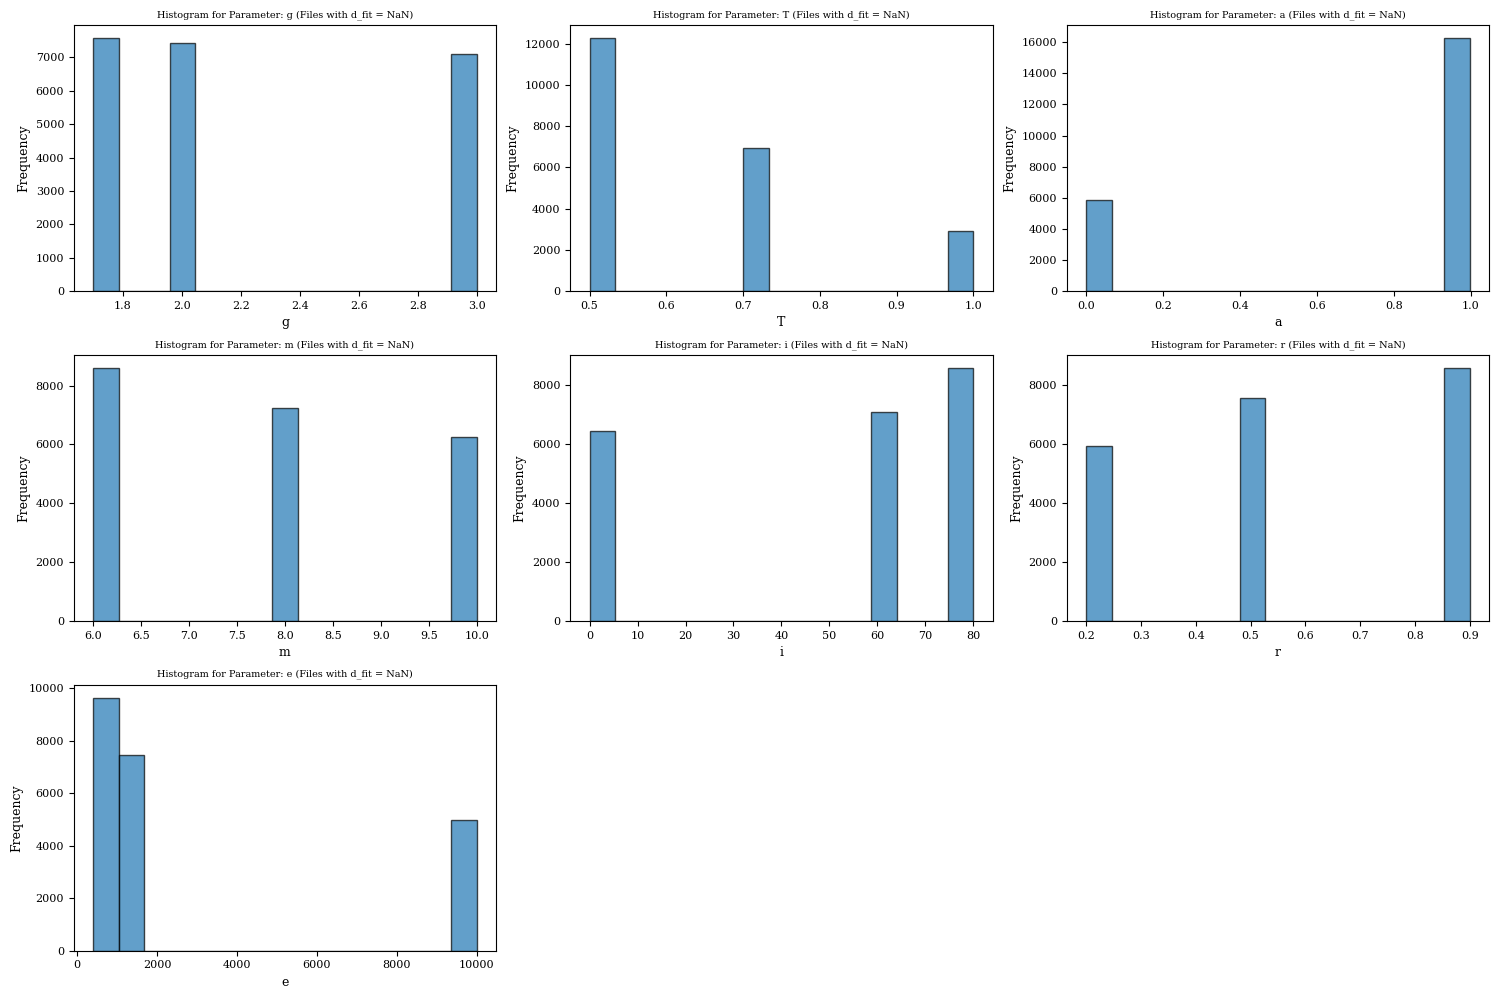

In [ ]:
# Plot histograms for each parameter in files that have 'd_fit' = NaN
plt.figure(figsize=(15, 10))
parameter_names = ['g', 'T', 'a', 'm', 'i', 'r', 'e']

# Iterate over parameters and plot histograms in a 2x3 layout
for idx, param_name in enumerate(parameter_names[:7]):  # Only using the first 6 parameters for the 2x3 layout
    values = [params[param_name] for params in na_d_fit_params if param_name in params]
    plt.subplot(3, 3, idx + 1)
    plt.hist(values, bins=15, edgecolor='black', alpha=0.7)
    plt.xlabel(param_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Parameter: {param_name} (Files with d_fit = NaN)')

plt.tight_layout()
plt.show()

# nH map of non-available distances

In [2]:
import sqlalchemy
import pandas as pd
import numpy as np

db = sqlalchemy.create_engine('sqlite:///results.db')
instr = 'maxi'
central_value = "d_fit_weighted_median"

try:
    with db.connect() as conn:
        print(f"Opened SQLite database with sqlalchemy version {sqlalchemy.__version__} successfully.")
        distances = (pd.read_sql('SELECT d FROM "'+instr+'" WHERE '+central_value+' IS NOT NULL AND r=0.5 AND T ==0.7 AND e=1500',conn))['d'].values
        na_distances = (pd.read_sql('SELECT d FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r=0.5 AND T ==0.7 AND e=1500',conn))['d'].values
        na_nH = (pd.read_sql('SELECT nH FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r=0.5 AND T ==0.7 AND e=1500',conn))['nH'].values
        # na_d_fit_params = (pd.read_sql('SELECT g,T,a,m,i,r,e FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r=0.9 AND T=1 AND e=1500',conn)).to_dict('records')

except Exception as e:
    print("Failed to open database:", e)

combinations_per_d_nH_bin = (len(distances) + len(na_distances))/(4*10)
print(combinations_per_d_nH_bin)

Opened SQLite database with sqlalchemy version 2.0.30 successfully.
54.0


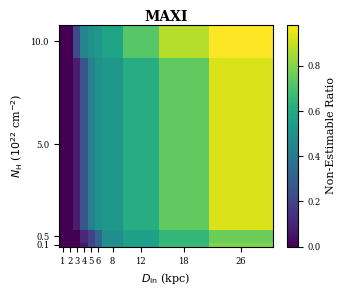

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Use LaTeX-style fonts if available and set global font sizes suitable for a one-column figure.
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 8,
})

# Define bin edges
x_bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 9.5, 14.5, 21.5, 30.5]
y_bins = [0, 0.2, 0.8, 9.2, 10.8]

# Compute the histogram using np.histogram2d to get counts
hist, x_edges, y_edges = np.histogram2d(na_distances, na_nH, bins=(x_bins, y_bins))

# Compute the ratio array (e.g. count/1458)
hist_ratio = hist / combinations_per_d_nH_bin

# Create a figure with a width suitable for one column (approx. 3.5 inches) and an appropriate height.
fig, ax = plt.subplots(figsize=(3.5, 3))

# Plot the ratio array using pcolormesh.
# Note: pcolormesh requires the data array shape to be (len(x_edges)-1, len(y_edges)-1)""
im = ax.pcolormesh(x_edges, y_edges, hist_ratio.T, cmap='viridis')

# Set axis labels
ax.set_xlabel(r'$D_{\text{in}}$ (kpc)')
ax.set_ylabel(r'$N_\text{H}$ ($10^{22}$ cm$^{-2}$)')
ax.set_title(f"{instr.upper()}", 
                 fontsize=10, 
                 fontweight='bold', 
                 x=0.5,       # center horizontally
                 y=0.98) 

# Add a colorbar that now reflects the ratio.
cb = fig.colorbar(im, ax=ax, label='Non-Estimable Ratio')

# Set tick marks only at the midpoints between the bin edges
x_ticks = (x_edges[:-1] + x_edges[1:]) / 2
y_ticks = (y_edges[:-1] + y_edges[1:]) / 2
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

# Annotate each cell with its ratio; adjust fontsize if necessary.
# for i in range(len(x_edges) - 1):
#     for j in range(len(y_edges) - 1):
#         ratio = hist[i, j] / combinations_per_d_nH_bin
#         ax.text((x_edges[i] + x_edges[i + 1]) / 2,
#                 (y_edges[j] + y_edges[j + 1]) / 2,
#                 f"{ratio:.1f}",
#                 ha='center', va='center', color='black', fontsize=6)

plt.tight_layout()
plt.savefig(f"plots/{instr}/nH-D_non_avail_map_{instr}.pdf", bbox_inches="tight")
plt.show()


In [3]:
low_ext = na_distances[na_nH == 0.1]
low_ext = low_ext[low_ext <= 12]
low_ext = low_ext[low_ext >= 1]
print(len(low_ext))
high_ext = na_distances[na_nH == 10]
high_ext = high_ext[high_ext <= 12]
high_ext = high_ext[high_ext >= 1]
print(len(high_ext))

87
161


# Half-violin plots (only run if using both instruments)

In [32]:
import sqlalchemy
import pandas as pd
import numpy as np

db = sqlalchemy.create_engine('sqlite:///results.db')
instr = 'all'
central_value = "d_fit_weighted_median"

try:
    with db.connect() as conn:
        print(f"Opened SQLite database with sqlalchemy version {sqlalchemy.__version__} successfully.")
        distances = (pd.read_sql('SELECT d FROM "'+instr+'" WHERE '+central_value+' IS NOT NULL AND r = 0.9 AND T = 1 AND (e=10000 or e=5000)',conn))['d'].values
        na_distances = (pd.read_sql('SELECT d FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r = 0.9 AND T = 1  AND (e=10000 or e=5000)',conn))['d'].values
        tight_distances_sql = (pd.read_sql('SELECT d FROM "'+instr+'" WHERE (ABS(diff_d)/'+central_value+') <= 0.5 AND r = 0.9 AND T = 1 AND (e=10000 or e=5000)',conn))['d'].values
        aggregated_data = pd.read_sql('SELECT * FROM "'+instr+'" WHERE r = 0.9 AND T = 1 AND (e=10000 or e=5000)',conn)
        tight_distances = (aggregated_data[(np.abs(aggregated_data['d']-aggregated_data[central_value])/aggregated_data['d']) <= 0.5])['d'].values
        na_nH = (pd.read_sql('SELECT nH FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r = 0.9 AND T = 1 AND (e=10000 or e=5000)',conn))['nH'].values
        na_d_fit_params = (pd.read_sql('SELECT g,T,a,m,i,r,e FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r = 0.9 AND T = 1 AND (e=10000 or e=5000)',conn)).to_dict('records')

except Exception as e:
    print("Failed to open database:", e)

Opened SQLite database with sqlalchemy version 2.0.30 successfully.


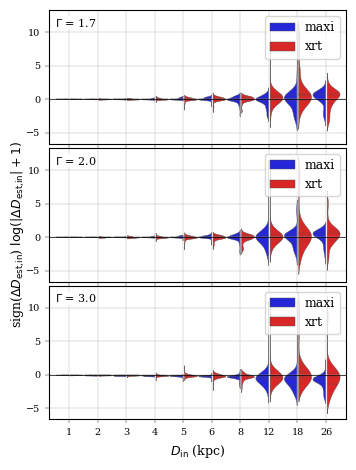

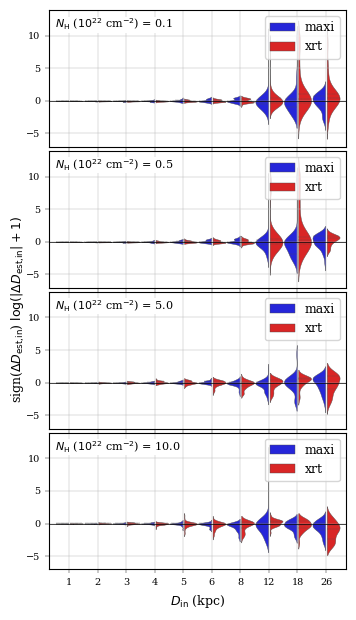

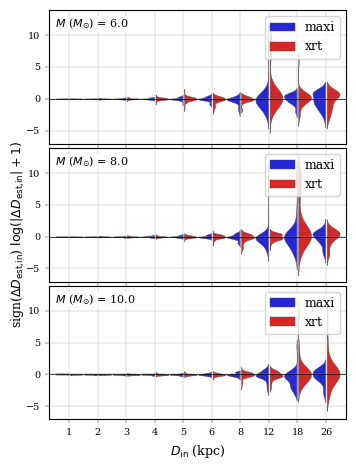

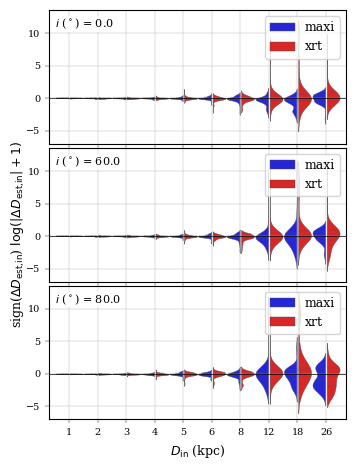

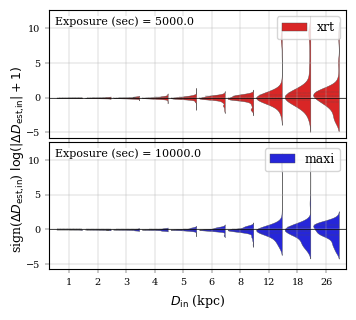

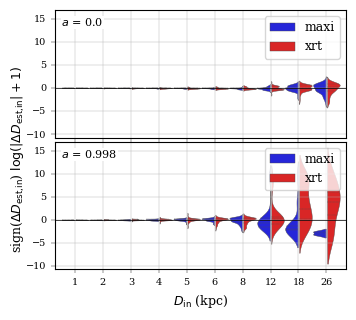

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Define the parameter labels with proper LaTeX formatting and units
parameter_labels = {
    'g': r"$\Gamma$",                        # Gamma (no unit label)
    'T': r"$T$ (keV)",                       # Temperature in keV
    'a': r"$a$",                              # Spin parameter (no unit label)
    'm': r"$M$ ($M_{\odot}$)",               # Mass in solar masses
    'i': r"$i$ ($^\circ$)",                   # Inclination in degrees
    'r': r"Disk-to-total ratio",             # Disk to total ratio (no unit label)
    'e': r"Exposure (sec)",                  # Exposure in seconds
    'nH': r"$N_\text{H}$ ($10^{22}$ cm$^{-2}$)"
}

# # Step 1: Attach parameters to each entry in all_data using all_data_params
# all_data_with_params = []
# for data_df, params in zip(all_data, all_data_params):  # Match each dataset with its parameters
#     # Repeat the parameter dictionary for each row in the corresponding data_df
#     params_df = pd.DataFrame([params] * len(data_df))
#     # Concatenate data and parameters
#     data_with_params = pd.concat([data_df.reset_index(drop=True), params_df.reset_index(drop=True)], axis=1)
#     all_data_with_params.append(data_with_params)
    
# # Step 2: Concatenate all entries into a single DataFrame
# all_data_flat = pd.concat(all_data_with_params, ignore_index=True)
# all_data_flat['diff_d'] = all_data_flat['d_fit_weighted_median'] - all_data_flat['d']

all_data_flat = aggregated_data

# Define the parameters to aggregate by
parameters = ['g', 'nH', 'm', 'i', 'e','a']

# Step 3: Loop through each parameter and create violin plots
for param in parameters:
    # Get unique values for the current parameter and distance
    param_values = sorted(all_data_flat[param].unique())
    d_values = sorted(all_data_flat['d'].unique())
    instr_values = sorted(all_data_flat['instr'].unique())

    # Create subplots for the current parameter
    fig, axes = plt.subplots(
        len(param_values), 1,
        figsize=(3.2, len(param_values) * 1.5),  # Single-column layout
        sharex=True,
        sharey=True
    )

    # Set vertical spacing between subplots to zero
    plt.subplots_adjust(hspace=0)  # No vertical space between panels

    # Iterate through each parameter value and plot distributions
    for i, (ax, val) in enumerate(zip(axes, param_values)):
        # Filter the data for the current parameter value
        subset = all_data_flat.loc[all_data_flat[param] == val].copy()
        instr_values = sorted(subset['instr'].unique())

        if len(instr_values) > 1:
            if not subset.empty:
                # subset['d'] = subset['d'].astype(str)  # Convert 'd' to string for categorical x-axis
                subset['logmod_diff_d'] = np.sign(subset['diff_d'].dropna()) * np.log(np.abs(subset['diff_d'].dropna())+1)
                # subset.rename(columns={"instr": "Instrument"},inplace=True)
                # ax.set_yscale('log')  # Use log scale for y-axis
                sns.violinplot(
                    data=subset,
                    x='d',
                    y='logmod_diff_d',
                    ax=ax,
                    hue='instr',  # Assign hue to the same as x-axis
                    inner='quart',  # No internal marks
                    hue_order=['maxi','xrt'],
                    split = True,
                    palette={"maxi": "b", "xrt": "r"},
                    linewidth=0.3,  # Reduced line width for clarity
                    density_norm='width', # Scale to equal width
                    gap=.1,
                    orient="v", # Vertical orientation
                    width=1,
                    saturation = 0.7
                )
        else:
            if not subset.empty:
                # subset['d'] = subset['d'].astype(str)  # Convert 'd' to string for categorical x-axis
                subset['logmod_diff_d'] = np.sign(subset['diff_d'].dropna()) * np.log(np.abs(subset['diff_d'].dropna())+1)
                # subset.rename(columns={"instr": "Instrument"},inplace=True)
                # ax.set_yscale('log')  # Use log scale for y-axis
                sns.violinplot(
                    data=subset,
                    x='d',
                    y='logmod_diff_d',
                    ax=ax,
                    hue='instr',  # Assign hue to the same as x-axis
                    inner='quart',  # No internal m,
                    palette={"maxi": "b", "xrt": "r"},
                    linewidth=0.3,  # Reduced line width for clarity
                    density_norm='width', # Scale to equal width
                    gap=.1,
                    orient="v", # Vertical orientation
                    width=1,
                    split=True,
                    saturation = 0.7
                )
                
        x_limits = ax.get_xlim()
        ax.plot([x_limits[0]-0.2, x_limits[1]+0.2], [0, 0], color='black', linestyle='-', linewidth=0.5)

        # Add titles inside the panel using parameter_labels
        ax.text(
            0.02, 0.95, f"{parameter_labels[param]} = {val}",
            transform=ax.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='none', pad=0.2)
        )

        # Add y-axis label for each subplot
        # ax.set_ylabel(r"$D_{\text{est}}$ (kpc)", fontsize=7, labelpad=2)
        # ax.set_ylabel(r"sign($\Delta D_{\text{est,in}}$) $\log(|\Delta D_{\text{est,in}}|+1)$", fontsize=7, labelpad=2)
        ax.set_ylabel("")

        # Add grid lines for better readability
        ax.grid(True, linewidth=0.3)

        # Adjust tick size to match label font size
        ax.tick_params(axis='both', which='major', labelsize=7, length=3, width=0.3)
        ax.tick_params(axis='both', which='minor', labelsize=7, length=2, width=0.3)

        # # Adjust the y-axis ticks explicitly for log scaling
        # ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=5))  # Max 5 major ticks
        # ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs="auto", numticks=10))  # Minor ticks
        ax.set_xlim([x_limits[0]-0.2, x_limits[1]+0.2])
        ax.legend(loc='upper right',fontsize=9)


    # Add x-axis label only for the bottom plot
    axes[-1].set_xlabel(r"$D_{\text{in}}$ (kpc)", fontsize=9)

    fig.text(-0.05, 0.5, r"sign($\Delta D_{\text{est,in}}$) $\log(|\Delta D_{\text{est,in}}|+1)$", va='center', rotation='vertical', fontsize=9)
       # Figure-level title (call this before tight_layout)
    # fig.suptitle(f"{instr.upper()}", 
    #              fontsize=10, 
    #              fontweight='bold', 
    #              x=0.5,       # center horizontally
    #              y=1) 

    # Adjust layout to ensure no overlaps and save the figure
    plt.tight_layout(pad=0.0)
    # plt.savefig(f"plots/{param}_violin_plot_both.png", dpi=600, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# Side by side histogram

In [1]:
import sqlalchemy
import pandas as pd
import numpy as np

db = sqlalchemy.create_engine('sqlite:///results.db')
instr = 'all'
central_value = "d_fit_weighted_median"

try:
    with db.connect() as conn:
        print(f"Opened SQLite database with sqlalchemy version {sqlalchemy.__version__} successfully.")
        distances = (pd.read_sql('SELECT d,instr FROM "'+instr+'" WHERE '+central_value+' IS NOT NULL AND r = 0.9 AND T = 1 AND a = 0 AND (e=10000 or e=5000)',conn))
        na_distances = (pd.read_sql('SELECT d,instr FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r = 0.9 AND T = 1 AND a = 0 AND (e=10000 or e=5000)',conn))
        tight_distances_sql = (pd.read_sql('SELECT d FROM "'+instr+'" WHERE (ABS(diff_d)/'+central_value+') <= 0.5  AND r = 0.9 AND T = 1 AND a = 0 AND (e=10000 or e=5000)',conn))['d'].values
        aggregated_data = pd.read_sql('SELECT * FROM "'+instr+'" WHERE r = 0.9 AND T = 1 AND a = 0 AND (e=10000 or e=5000)',conn)
        tight_distances = (aggregated_data[(np.abs(aggregated_data['d']-aggregated_data[central_value])/aggregated_data['d']) <= 0.1])
        not_tight_distances = (aggregated_data[~((np.abs(aggregated_data['d']-aggregated_data[central_value])/aggregated_data['d']) <= 0.1)])
        na_nH = (pd.read_sql('SELECT nH FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r = 0.9 AND T = 1 AND a = 0 AND (e=10000 or e=5000)',conn))['nH'].values
        na_d_fit_params = (pd.read_sql('SELECT g,T,a,m,i,r,e FROM "'+instr+'" WHERE '+central_value+' IS NULL AND r = 0.9 AND T = 1 AND a = 0 AND (e=10000 or e=5000)',conn)).to_dict('records')

except Exception as e:
    print("Failed to open database:", e)

Opened SQLite database with sqlalchemy version 2.0.30 successfully.


In [3]:

# Instrument 1: Two categories (e.g., 'Estimated' and 'Not Estimated')
data1_catA = tight_distances[ tight_distances['instr'] =='maxi' ]['d'].values
data1_catB = not_tight_distances[ not_tight_distances['instr'] =='maxi' ]['d'].values

# Instrument 2: Two categories (e.g., 'Estimated' and 'Not Estimated')
data2_catA = tight_distances[ tight_distances['instr'] =='xrt' ]['d'].values
data2_catB = not_tight_distances[ not_tight_distances['instr'] =='xrt' ]['d'].values


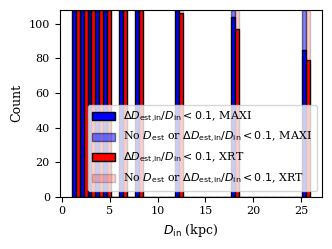

In [89]:
import numpy as np
import matplotlib.pyplot as plt


# ---------------------------
# Define common bins for all datasets
# ---------------------------
# Combine all data to determine a common range
all_data = np.concatenate([data1_catA, data1_catB, data2_catA, data2_catB])
num_bins = 30
bins = np.linspace(all_data.min(), all_data.max(), num_bins + 1)

# ---------------------------
# Compute histogram counts for each category
# ---------------------------
counts1_catA, _ = np.histogram(data1_catA, bins=bins)
counts1_catB, _ = np.histogram(data1_catB, bins=bins)
counts2_catA, _ = np.histogram(data2_catA, bins=bins)
counts2_catB, _ = np.histogram(data2_catB, bins=bins)

# ---------------------------
# Determine bin centers and bar widths
# ---------------------------
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

# We'll use an offset to place the groups side by side
offset = bin_width / 4
bar_width = bin_width / 2  # Each grouped bar takes up half of the bin width

# ---------------------------
# Create the plot
# ---------------------------
fig, ax = plt.subplots(figsize=(10/3, 2.5))

# Plot Instrument 1 (shifted to the left)
# Plot the first (bottom) category:
bar1 = ax.bar(bin_centers - offset, counts1_catA, width=bar_width,
              color='blue', alpha=1, edgecolor='black', label=r'$\Delta D_{\text{est,in}}/D_{\text{in}} < 0.1$, MAXI')
# Plot the second category on top (stacked):
bar2 = ax.bar(bin_centers - offset, counts1_catB, width=bar_width,
              bottom=counts1_catA, color='blue', alpha=0.5, edgecolor='black', label=r'No $D_{\text{est}}$ or $\Delta D_{\text{est,in}}/D_{\text{in}} < 0.1$, MAXI')

# Plot Instrument 2 (shifted to the right)
bar3 = ax.bar(bin_centers + offset, counts2_catA, width=bar_width,
              color='red', alpha=1, edgecolor='black', label=r'$\Delta D_{\text{est,in}}/D_{\text{in}} < 0.1$, XRT')
bar4 = ax.bar(bin_centers + offset, counts2_catB, width=bar_width,
              bottom=counts2_catA, color='red', alpha=0.2, edgecolor='black', label=r'No $D_{\text{est}}$ or $\Delta D_{\text{est,in}}/D_{\text{in}} < 0.1$, XRT')

# ---------------------------
# Customize the plot
# ---------------------------
ax.set_ylabel('Count')
ax.set_xlabel(r'$D_{\text{in}}$ (kpc)')
# ax.set_title('Side-by-Side Stacked Histograms')
ax.legend()

plt.tight_layout()
# Save the figure in a high-resolution format suitable for publication
plt.savefig(f'plots/stacked_histogram_distances_both_filtered.pdf', dpi=600)
plt.show()


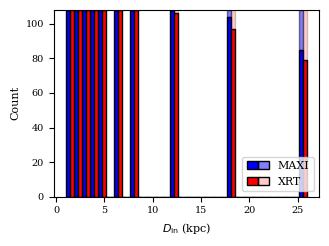

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

# ---------------------------
# Custom classes for split legend patch
# ---------------------------
class SplitPatch(mpatches.Patch):
    def __init__(self, facecolor1, facecolor2, edgecolor='black', **kwargs):
        # Store the two facecolors (each is an RGBA tuple)
        self.facecolor1 = facecolor1
        self.facecolor2 = facecolor2
        self.edgecolor = edgecolor
        # Use one of the colors for the base Patch initialization
        super().__init__(facecolor=facecolor1, edgecolor=edgecolor, **kwargs)

class HandlerSplitPatch(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # Create two adjacent rectangles: left half and right half
        left = mpatches.Rectangle([xdescent, ydescent],
                                  width/2, height,
                                  facecolor=orig_handle.facecolor1,
                                  edgecolor=orig_handle.edgecolor)
        right = mpatches.Rectangle([xdescent + width/2, ydescent],
                                   width/2, height,
                                   facecolor=orig_handle.facecolor2,
                                   edgecolor=orig_handle.edgecolor)
        left.set_transform(trans)
        right.set_transform(trans)
        return [left, right]

# ---------------------------
# Your existing histogram plotting code
# ---------------------------
# (Assuming data1_catA, data1_catB, data2_catA, data2_catB are defined)

# Combine all data to determine a common range
all_data = np.concatenate([data1_catA, data1_catB, data2_catA, data2_catB])
num_bins = 30
bins = np.linspace(all_data.min(), all_data.max(), num_bins + 1)

# Compute histogram counts for each category
counts1_catA, _ = np.histogram(data1_catA, bins=bins)
counts1_catB, _ = np.histogram(data1_catB, bins=bins)
counts2_catA, _ = np.histogram(data2_catA, bins=bins)
counts2_catB, _ = np.histogram(data2_catB, bins=bins)

# Determine bin centers and bar widths
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

offset = bin_width / 4
bar_width = bin_width / 2

fig, ax = plt.subplots(figsize=(10/3, 2.5))

# Plot Instrument 1 (shifted to the left)
ax.bar(bin_centers - offset, counts1_catA, width=bar_width,
       color='blue', alpha=1, edgecolor='black')
ax.bar(bin_centers - offset, counts1_catB, width=bar_width,
       bottom=counts1_catA, color='blue', alpha=0.5, edgecolor='black')

# Plot Instrument 2 (shifted to the right)
ax.bar(bin_centers + offset, counts2_catA, width=bar_width,
       color='red', alpha=1, edgecolor='black')
ax.bar(bin_centers + offset, counts2_catB, width=bar_width,
       bottom=counts2_catA, color='red', alpha=0.2, edgecolor='black')

ax.set_ylabel('Count')
ax.set_xlabel(r'$D_{\text{in}}$ (kpc)')

# ---------------------------
# Create custom legend handles
# ---------------------------
# Define RGBA colors for the two halves
# For MAXI (blue): left half (full opacity), right half (alpha=0.5)
blue_full = (0, 0, 1, 1)      # blue, fully opaque
blue_trans = (0, 0, 1, 0.5)   # blue, semi-transparent

# For XRT (red): left half (full opacity), right half (alpha=0.2)
red_full = (1, 0, 0, 1)       # red, fully opaque
red_trans = (1, 0, 0, 0.2)    # red, more transparent

maxi_handle = SplitPatch(facecolor1=blue_full, facecolor2=blue_trans, edgecolor='black')
xrt_handle  = SplitPatch(facecolor1=red_full,  facecolor2=red_trans,  edgecolor='black')

# Create the legend using the custom handler. Only two entries: MAXI and XRT.
ax.legend(handles=[maxi_handle, xrt_handle], labels=['MAXI', 'XRT'],
          handler_map={SplitPatch: HandlerSplitPatch()},loc='lower right')

plt.tight_layout()
plt.savefig('plots/stacked_histogram_distances_both_filtered.pdf', dpi=600)
plt.show()


In [10]:
# Side by side histogram
import sqlalchemy
import pandas as pd
import numpy as np

db = sqlalchemy.create_engine('sqlite:///results.db')
instr = 'all'
central_value = "d_fit_weighted_median"

try:
    with db.connect() as conn:
        print(f"Opened SQLite database with sqlalchemy version {sqlalchemy.__version__} successfully.")
        aggregated_data = pd.read_sql('SELECT * FROM "'+instr+'" WHERE r = 0.2 AND T = 0.5 AND a = 0.998 AND e=400',conn)
        tight_distances = (aggregated_data[(np.abs(aggregated_data['d']-aggregated_data[central_value])/aggregated_data['d']) <= 0.1])
        not_tight_distances = (aggregated_data[~((np.abs(aggregated_data['d']-aggregated_data[central_value])/aggregated_data['d']) <= 0.1)])
except Exception as e:
    print("Failed to open database:", e)

Opened SQLite database with sqlalchemy version 2.0.30 successfully.


In [11]:

# Instrument 1: Two categories (e.g., 'Estimated' and 'Not Estimated')
data1_catA = tight_distances[ tight_distances['instr'] =='maxi' ]['d'].values
data1_catB = not_tight_distances[ not_tight_distances['instr'] =='maxi' ]['d'].values

# Instrument 2: Two categories (e.g., 'Estimated' and 'Not Estimated')
data2_catA = tight_distances[ tight_distances['instr'] =='xrt' ]['d'].values
data2_catB = not_tight_distances[ not_tight_distances['instr'] =='xrt' ]['d'].values


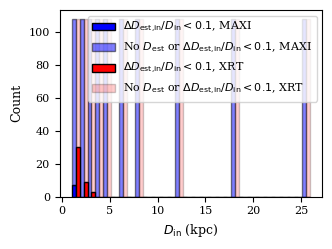

In [92]:
import numpy as np
import matplotlib.pyplot as plt


# ---------------------------
# Define common bins for all datasets
# ---------------------------
# Combine all data to determine a common range
all_data = np.concatenate([data1_catA, data1_catB, data2_catA, data2_catB])
num_bins = 30
bins = np.linspace(all_data.min(), all_data.max(), num_bins + 1)

# ---------------------------
# Compute histogram counts for each category
# ---------------------------
counts1_catA, _ = np.histogram(data1_catA, bins=bins)
counts1_catB, _ = np.histogram(data1_catB, bins=bins)
counts2_catA, _ = np.histogram(data2_catA, bins=bins)
counts2_catB, _ = np.histogram(data2_catB, bins=bins)

# ---------------------------
# Determine bin centers and bar widths
# ---------------------------
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

# We'll use an offset to place the groups side by side
offset = bin_width / 4
bar_width = bin_width / 2  # Each grouped bar takes up half of the bin width

# ---------------------------
# Create the plot
# ---------------------------
fig, ax = plt.subplots(figsize=(10/3, 2.5))

# Plot Instrument 1 (shifted to the left)
# Plot the first (bottom) category:
bar1 = ax.bar(bin_centers - offset, counts1_catA, width=bar_width,
              color='blue', alpha=1, edgecolor='black', label=r'$\Delta D_{\text{est,in}}/D_{\text{in}} < 0.1$, MAXI')
# Plot the second category on top (stacked):
bar2 = ax.bar(bin_centers - offset, counts1_catB, width=bar_width,
              bottom=counts1_catA, color='blue', alpha=0.5, edgecolor='black', label=r'No $D_{\text{est}}$ or $\Delta D_{\text{est,in}}/D_{\text{in}} < 0.1$, MAXI')

# Plot Instrument 2 (shifted to the right)
bar3 = ax.bar(bin_centers + offset, counts2_catA, width=bar_width,
              color='red', alpha=1, edgecolor='black', label=r'$\Delta D_{\text{est,in}}/D_{\text{in}} < 0.1$, XRT')
bar4 = ax.bar(bin_centers + offset, counts2_catB, width=bar_width,
              bottom=counts2_catA, color='red', alpha=0.2, edgecolor='black', label=r'No $D_{\text{est}}$ or $\Delta D_{\text{est,in}}/D_{\text{in}} < 0.1$, XRT')

# ---------------------------
# Customize the plot
# ---------------------------
ax.set_ylabel('Count')
ax.set_xlabel(r'$D_{\text{in}}$ (kpc)')
# ax.set_title('Side-by-Side Stacked Histograms')
ax.legend()

plt.tight_layout()
# Save the figure in a high-resolution format suitable for publication
plt.savefig(f'plots/stacked_histogram_distances_both_filtered2.pdf', dpi=600)
plt.show()

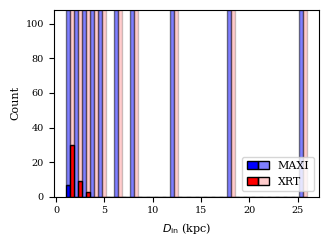

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

# ---------------------------
# Custom classes for split legend patch
# ---------------------------
class SplitPatch(mpatches.Patch):
    def __init__(self, facecolor1, facecolor2, edgecolor='black', **kwargs):
        # Store the two facecolors (each is an RGBA tuple)
        self.facecolor1 = facecolor1
        self.facecolor2 = facecolor2
        self.edgecolor = edgecolor
        # Use one of the colors for the base Patch initialization
        super().__init__(facecolor=facecolor1, edgecolor=edgecolor, **kwargs)

class HandlerSplitPatch(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # Create two adjacent rectangles: left half and right half
        left = mpatches.Rectangle([xdescent, ydescent],
                                  width/2, height,
                                  facecolor=orig_handle.facecolor1,
                                  edgecolor=orig_handle.edgecolor)
        right = mpatches.Rectangle([xdescent + width/2, ydescent],
                                   width/2, height,
                                   facecolor=orig_handle.facecolor2,
                                   edgecolor=orig_handle.edgecolor)
        left.set_transform(trans)
        right.set_transform(trans)
        return [left, right]

# ---------------------------
# Your existing histogram plotting code
# ---------------------------
# (Assuming data1_catA, data1_catB, data2_catA, data2_catB are defined)

# Combine all data to determine a common range
all_data = np.concatenate([data1_catA, data1_catB, data2_catA, data2_catB])
num_bins = 30
bins = np.linspace(all_data.min(), all_data.max(), num_bins + 1)

# Compute histogram counts for each category
counts1_catA, _ = np.histogram(data1_catA, bins=bins)
counts1_catB, _ = np.histogram(data1_catB, bins=bins)
counts2_catA, _ = np.histogram(data2_catA, bins=bins)
counts2_catB, _ = np.histogram(data2_catB, bins=bins)

# Determine bin centers and bar widths
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

offset = bin_width / 4
bar_width = bin_width / 2

fig, ax = plt.subplots(figsize=(10/3, 2.5))

# Plot Instrument 1 (shifted to the left)
ax.bar(bin_centers - offset, counts1_catA, width=bar_width,
       color='blue', alpha=1, edgecolor='black')
ax.bar(bin_centers - offset, counts1_catB, width=bar_width,
       bottom=counts1_catA, color='blue', alpha=0.5, edgecolor='black')

# Plot Instrument 2 (shifted to the right)
ax.bar(bin_centers + offset, counts2_catA, width=bar_width,
       color='red', alpha=1, edgecolor='black')
ax.bar(bin_centers + offset, counts2_catB, width=bar_width,
       bottom=counts2_catA, color='red', alpha=0.2, edgecolor='black')

ax.set_ylabel('Count')
ax.set_xlabel(r'$D_{\text{in}}$ (kpc)')
ax.set_ylim(top=108)

# ---------------------------
# Create custom legend handles
# ---------------------------
# Define RGBA colors for the two halves
# For MAXI (blue): left half (full opacity), right half (alpha=0.5)
blue_full = (0, 0, 1, 1)      # blue, fully opaque
blue_trans = (0, 0, 1, 0.5)   # blue, semi-transparent

# For XRT (red): left half (full opacity), right half (alpha=0.2)
red_full = (1, 0, 0, 1)       # red, fully opaque
red_trans = (1, 0, 0, 0.2)    # red, more transparent

maxi_handle = SplitPatch(facecolor1=blue_full, facecolor2=blue_trans, edgecolor='black')
xrt_handle  = SplitPatch(facecolor1=red_full,  facecolor2=red_trans,  edgecolor='black')

# Create the legend using the custom handler. Only two entries: MAXI and XRT.
ax.legend(handles=[maxi_handle, xrt_handle], labels=['MAXI', 'XRT'],
          handler_map={SplitPatch: HandlerSplitPatch()},loc='lower right')

plt.tight_layout()
plt.savefig('plots/stacked_histogram_distances_both_filtered2.pdf', dpi=600)
plt.show()
